## SPUR Densification Survey- Natural Langugage Processing Project
notebook author: Emily Robitschek

#### Background information on survey: 
This survey was conducted by the SPUR group at ETH: https://spur.ethz.ch/

#### Hypothesis/Research question: 
Can we use the open text field responses from densification surveys to infer something about the motivations behind why individuals responded the way they did to the densification survey?

**Runtime $\sim$ 20min**

## Stage 3: Topic modelling of the pre-processed data with LDA
To move beyond top individual words and better characterize themes themes or “topics” in the responses that don’t rely as much on a pre-stratification of the data along a particular response category, I carried out further preprocessing and topic modelling on the text data. Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data, which finds some natural groups of items (topics). Topic modeling techniques (specifically Latent Dirichlet Allocation or LDA) have been successfully applied in the context of NLP and text data to extract the main themes from the document collection without having to define them based on a priori expectations, although such methods have their limitations.

#### Execute the following code to use spacy features if this model isn't downloaded in the environment already (more info here: https://spacy.io/usage)

In [1]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.6 MB 4.7 MB/s eta 0:00:01
You should consider upgrading via the '/Users/emilyrobitschek/opt/anaconda3/envs/relatio_env/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### import necessary packages: 

In [2]:
import pandas as pd
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import seaborn as sns
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words (extend if desired)
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['proposal', 'proposals'])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emilyrobitschek/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
## Helper functions

#from this post: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#18dominanttopicineachsentence

# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

        
def get_perplexity_coherence(lda_model, corpus, data_lemmatized, id2word, coherence='c_v'): 
    """Return perplexity and coherence for lda model."""
    # Compute Perplexity
    perplexity = lda_model.log_perplexity(corpus)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return perplexity, coherence_lda
    

def score_lda_model(min_topic_num, max_topic_num, lda_model, corpus, data_lemmatized, id2word):
    """Return perplexity and coherence for different number of topics for lda model."""
    perplexities = []
    coherences = []
    topic_nums_to_try = list(range(min_topic_num, max_topic_num))
    for num in topic_nums_to_try: 
        print('Running LDA with %d topics' % (num))
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        perplexity, coherence = get_perplexity_coherence(lda_model, corpus, data_lemmatized, id2word, coherence='c_v')
        perplexities.append(perplexity)
        coherences.append(coherence)
    lda_model_eval_df = pd.DataFrame({'number_of_topics': topic_nums_to_try, 
                                 'perplexity': perplexities, 
                                 'coherence': coherences})
    return lda_model_eval_df



### Load in data

In [4]:
subset_col = 'Q12.6_corrected' #specify corrected text column
survey_df = pd.read_csv('../datasets/spur_survey_response_filtered_df1.txt', sep='\t')
survey_df.head()

,StartDate,EndDate,Progress,Duration..in.seconds.,Finished,RecordedDate,ResponseId,LocationLatitude,LocationLongitude,UserLanguage,...,Q14.1_1,Q14.3,Q14.5,Q14.7,Q14.9,age,city,country,Q12.6_corrected,response_char_length
0,18.02.21 06:18,18.02.21 06:23,100.0,300.0,Richtig,18.02.21 06:23,R_10PI5FKTTlId8Ec,41.606201,-87.259300,EN-GB,...,5.0,6.0,6.0,Quite concerned,Neither,18-24,Chicago,United States,I'm not yo I'm not talking to you,34
1,18.02.21 06:41,18.02.21 06:55,100.0,894.0,Richtig,18.02.21 06:55,R_1gduid1fizdQ4d8,37.983398,-122.031204,EN-GB,...,6.0,9.0,9.0,Very concerned,Very concerned,35-44,Chicago,United States,It is the way it is,19
2,18.02.21 06:45,18.02.21 06:57,100.0,681.0,Richtig,18.02.21 06:57,R_23WCgmyuPAy3b1G,41.741501,-87.596199,EN-GB,...,1.0,9.0,4.0,Very concerned,Very concerned,18-24,Chicago,United States,Because it would be more fair to people that d...,60
3,18.02.21 06:56,18.02.21 07:11,100.0,941.0,Richtig,18.02.21 07:11,R_1pLEMXp5iJbankG,41.920898,-87.704300,EN-GB,...,7.0,10.0,5.0,Neither,Neither,35-44,Chicago,United States,I choose proposal 2 because you offered me bet...,74
4,18.02.21 09:38,18.02.21 09:50,100.0,676.0,Richtig,18.02.21 09:50,R_2OYEXKWutkzQOmS,42.048706,-87.890503,EN-GB,...,1.0,8.0,9.0,Very concerned,Very concerned,18-24,Chicago,United States,Because I felt like it wouldn't be good enough...,54


### Preprocess data for model

In [5]:
#specify text data
data = survey_df[subset_col]
pprint(data[:1])

data_words = list(sent_to_words(data))
print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=80) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=80)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

0    I'm not yo I'm not talking to you 
Name: Q12.6_corrected, dtype: object
[['not', 'yo', 'not', 'talking', 'to', 'you']]
['not', 'yo', 'not', 'talking', 'to', 'you']


In [6]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:5])

[['talk'], ['way'], ['fair', 'people', 'much'], ['choose', 'offer', 'well', 'thing'], ['feel', 'good', 'enough']]


In [7]:
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('talk', 1)],
 [('way', 1)],
 [('fair', 1), ('much', 1), ('people', 1)],
 [('choose', 1), ('offer', 1), ('thing', 1), ('well', 1)],
 [('enough', 1), ('feel', 1), ('good', 1)],
 [('people', 1),
  ('also', 2),
  ('apartment', 1),
  ('beneficial', 1),
  ('cafe', 1),
  ('community', 1),
  ('craft', 1),
  ('density', 1),
  ('draw', 1),
  ('idea', 1),
  ('low', 1),
  ('mixed_use', 1),
  ('neighborhood', 1),
  ('often', 1),
  ('oppose', 1),
  ('prefer', 1),
  ('resident', 1),
  ('restaurant', 1),
  ('surround', 1),
  ('think', 1)],
 [('well', 1), ('one', 1), ('sound', 1)],
 [('well', 1), ('position', 1)],
 [('good', 1), ('survey', 1)],
 [('density', 1), ('double', 1), ('want', 1)]]

### Build model (LDA) and assess performance across K

In [8]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [9]:
lda_model_eval_df = score_lda_model(8, 14, lda_model, corpus, data_lemmatized, id2word)
lda_model_eval_df

Running LDA with 8 topics
Running LDA with 9 topics
Running LDA with 10 topics
Running LDA with 11 topics
Running LDA with 12 topics
Running LDA with 13 topics


,number_of_topics,perplexity,coherence
0,8,-6.726542,0.426483
1,9,-6.781376,0.390834
2,10,-6.916933,0.404417
3,11,-7.067676,0.435134
4,12,-7.359074,0.408527
5,13,-7.823154,0.440365


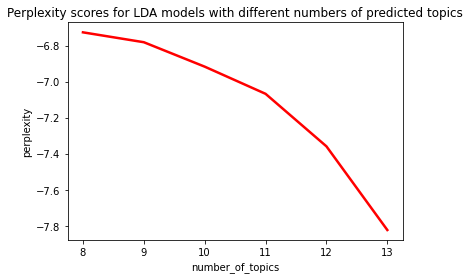

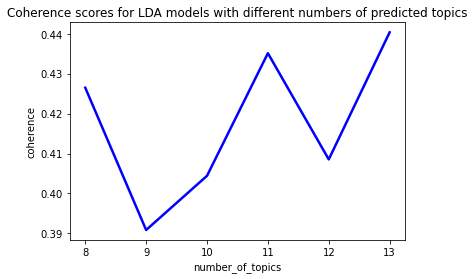

In [10]:
#Plot perplexity across K
sns.lineplot(data=lda_model_eval_df, x="number_of_topics", y="perplexity", 
             color='red', linewidth=2.5)
title = ("Perplexity scores for LDA models with different numbers of predicted topics")
plt.xticks(lda_model_eval_df["number_of_topics"])
plt.title(title)
plt.show()


#Plot coherence across K
sns.lineplot(data=lda_model_eval_df, x="number_of_topics", y="coherence",
            color='blue', linewidth=2.5)
title = ("Coherence scores for LDA models with different numbers of predicted topics")
plt.xticks(lda_model_eval_df["number_of_topics"])
plt.title(title)
plt.show()

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 11 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.147*"community" + 0.128*"want" + 0.076*"feel" + 0.060*"change" + '
  '0.055*"really" + 0.043*"decision" + 0.037*"involve" + 0.030*"choice" + '
  '0.024*"house" + 0.022*"love"'),
 (1,
  '0.222*"good" + 0.203*"housing" + 0.175*"affordable" + 0.030*"support" + '
  '0.029*"accept" + 0.021*"dense" + 0.020*"general" + 0.018*"consider" + '
  '0.012*"appeal" + 0.011*"select"'),
 (2,
  '0.087*"live" + 0.063*"decide" + 0.053*"thing" + 0.046*"look" + 0.045*"way" '
  '+ 0.043*"certain" + 0.040*"say" + 0.037*"time" + 0.033*"see" + '
  '0.030*"cost"'),
 (3,
  '0.158*"prefer" + 0.096*"government" + 0.096*"help" + 0.094*"involvement" + '
  '0.026*"participation" + 0.024*"national" + 0.022*"trust" + 0.022*"non" + '
  '0.018*"deal" + 0.017*"developer"'),
 (4,
  '0.166*"people" + 0.130*"neighborhood" + 0.073*"area" + 0.048*"less" + '
  '0.040*"city" + 0.036*"idea" + 0.025*"development" + 0.024*"mixed_use" + '
  '0.022*"survey" + 0.021*"bad"'),
 (5,
  '0.261*"rent" + 0.139*"control" + 0.072*"nee

In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
# Visualize the topics
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics=False)
print(vis_data.topic_order)
vis_data

/Users/emilyrobitschek/opt/anaconda3/envs/relatio_env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.055770  0.029584       1        1   6.782927
1     -0.047185  0.026419       2        1   8.436846
2     -0.060535  0.033419       3        1   8.396314
3     -0.066351  0.029995       4        1   3.575877
4     -0.046521  0.028897       5        1  10.075482
5      0.414817  0.146611       6        1  16.635809
6     -0.060941  0.031435       7        1   6.711160
7     -0.059719  0.031460       8        1   7.758959
8      0.105912 -0.422646       9        1  15.406358
9     -0.059973  0.033666      10        1   9.472029
10    -0.063732  0.031160      11        1   6.748240, topic_info=          Term         Freq        Total Category  logprob  loglift
69        rent  1186.000000  1186.000000  Default  30.0000  30.0000
55    increase   782.000000   782.000000  Default  29.0000  29.0000
11        good   512.000000   512.000000  Default  28.0000  28.0000
42     housing   469.000000   469.000000  Default  27.0000  27.0000
92     control   630.000000   630.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
850   per_year    14.026369    14.897653  Topic11  -4.8786   2.6356
1198  hospital    13.799290    14.670735  Topic11  -4.8949   2.6347
689       stop    13.605985    14.477251  Topic11  -4.9090   2.6338
1140   several    11.736520    12.608543  Topic11  -5.0569   2.6242
1176  facility    11.441978    12.313333  Topic11  -5.0823   2.6225

[360 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
204      11  0.953466        able
198       2  0.982630      accept
276       2  0.932910    actually
374       5  0.959314         add
332       3  0.967695  additional
...     ...       ...         ...
8         8  0.996299        well
1071      5  0.949525       whole
210      11  0.991627        work
430       2  0.974345       write
368      10  0.978948        year

[330 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

### Build model (LDAMallet) and assess performance across K
https://stackoverflow.com/questions/62581874/gensim-ldamallet-vs-ldamodel

In [14]:
mallet_path = '../resources/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 117
total tokens: 22186
<10> LL/token: -8.15181
<20> LL/token: -7.86288
<30> LL/token: -7.68946
<40> LL/token: -7.54273

0	5	rent resident option people choose neighborhood housing thing good environment family agree change service control support fit raise project sound 
1	5	rent good low affordable price give cap prefer local people increase housing thing community benefit depend project fair densification mixed 
2	5	housing people profit rent development affordable high plan international government cost benefit create love social survey level interesting make future 
3	5	density building apartment business increase rent city climate time pay prefer housing project home development densification safe income residential favor 
4	5	rent population affordable housing density opinion favor increase project base idea involve people decision control add high bring work current 
5	5	control rent increase resident

<260> LL/token: -6.80812
<270> LL/token: -6.81197
<280> LL/token: -6.82206
<290> LL/token: -6.81562

0	5	good people thing choose option agree decide family environment service pick nice job fit mixed income sound situation concern interesting 
1	5	rent cap low benefit percentage generally local good accept fair densification depend increase survey investment care appeal due acceptable neighbourhood 
2	5	housing affordable profit development high low_income plan social love amount living create future private developer tenant carbon_neutral personal question happen 
3	5	community favor building apartment business city time pay house space home add mix long money impact rent raise level residential 
4	5	resident project feel idea involvement decision opinion base great involve small choice bring work give safe opportunity current easy reasonable 
5	5	rent control important climate change mixed_use year landlord consideration reason grow comfortable protect fix society zero_emission supp

<510> LL/token: -6.77909
<520> LL/token: -6.78268
<530> LL/token: -6.77821
<540> LL/token: -6.75887

0	5	good people decide thing choose option benefit feel agree service nice pick job sound fit situation interesting neighbourhood personal interested 
1	5	rent cap low increase generally percentage local densification emission accept fair depend investment survey rate landlord care citizen small_businesse love 
2	5	housing affordable profit development include low_income plan social amount living current developer tenant carbon_neutral unit view specific happen condition person 
3	5	community favor building apartment business city time lot neighborhood house pay mix space give home long add hard dense mixed 
4	5	resident project idea involvement great feel decision opinion base choice bring involve small opportunity cost reduce easy matter tend participation 
5	5	rent control important change mixed_use climate consideration aspect small push policy expensive addition side group green_sp

<760> LL/token: -6.77289
<770> LL/token: -6.78572
<780> LL/token: -6.78834
<790> LL/token: -6.79025

0	5	good people decide choose option benefit thing agree reason pick nice job sound fit expensive future interesting neighbourhood personal suit 
1	5	rent cap control high percentage cost local emission depend landlord generally fair limit accept income living main view affordability question 
2	5	housing affordable profit development include favour plan social low_income amount citizen rate developer tenant carbon_neutral due part unit carbon shop 
3	5	community building apartment business favor city time house give mix space pay service home long add money build dense big 
4	5	resident feel community involvement idea great decision opinion base involve small bring choice survey concern beneficial project situation love easy 
5	5	rent control climate important change mixed_use factor consideration mind aspect make work push maximum key favour borough specification negative protection 


In [15]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('good', 0.21685649202733484),
   ('people', 0.0633257403189066),
   ('decide', 0.05649202733485194),
   ('thing', 0.05056947608200456),
   ('choose', 0.04738041002277904),
   ('option', 0.04510250569476082),
   ('benefit', 0.04191343963553531),
   ('agree', 0.03507972665148064),
   ('environment', 0.030068337129840545),
   ('reason', 0.01776765375854214)]),
 (1,
  [('rent', 0.25965858041329737),
   ('cap', 0.08221024258760108),
   ('high', 0.07637017070979335),
   ('control', 0.07502246181491465),
   ('favor', 0.034141958670260555),
   ('generally', 0.03234501347708895),
   ('cost', 0.024707996406109614),
   ('emission', 0.019766397124887692),
   ('find', 0.014375561545372867),
   ('limit', 0.01302785265049416)]),
 (2,
  [('housing', 0.24335286164939163),
   ('affordable', 0.1694456962595764),
   ('development', 0.04821991888237945),
   ('include', 0.032897701667417754),
   ('percentage', 0.03244704821991888),
   ('favour', 0.029743127534925643),
   ('bring', 0.024785939612438

In [16]:
#using this function that can take a long time to run from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ 
#because mine includes perplexity and that gave me some initial issues

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=data_lemmatized, start=5, limit=20, step=1)

Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 117
total tokens: 22186
<10> LL/token: -7.66383
<20> LL/token: -7.45671
<30> LL/token: -7.36899
<40> LL/token: -7.26069

0	10	rent housing affordable favor control important increase decide percentage population house cost low_income problem people social emission good change survey 
1	10	rent control prefer increase housing density cap resident thing high climate area good mixed_use investor city give bad service offer 
2	10	rent increase density good control live feel people development project profit opinion apartment include population bring base choice prefer factor 
3	10	increase population community area density idea resident choose great people option good decision involvement generally housing building business high general 
4	10	people rent neighborhood good make increase investor density agree climate building government lot low change local international work small price 

<50> LL/token: -7.16932
<6

<460> LL/token: -6.60194
<470> LL/token: -6.61523
<480> LL/token: -6.61798
<490> LL/token: -6.60157

0	10	housing affordable important climate decide rent agree percentage cost issue factor densification house low_income build problem emission social survey love 
1	10	rent control resident prefer cap low apartment thing business include percent favour mixed_use non_profit input small fair requirement landlord beneficial 
2	10	good neighborhood community favor feel project development profit option involvement benefit city decision opinion base local choice vote bad bring 
3	10	increase density population choose idea great high generally public support life general infrastructure large traffic crime pick nice neutral investment 
4	10	people area live make investor building change government high lot environment time involve price place family pay give offer space 

<500> LL/token: -6.59762
<510> LL/token: -6.60154
<520> LL/token: -6.60304
<530> LL/token: -6.60945
<540> LL/token: -6.6131

<960> LL/token: -6.58499
<970> LL/token: -6.57108
<980> LL/token: -6.57138
<990> LL/token: -6.57317

0	10	housing affordable climate important decide involvement build change agree percentage cost issue factor densification house vote plan social emission favor 
1	10	rent control resident prefer cap investor low thing business include percent mixed_use non_profit input small low_income international mix fair apartment 
2	10	good neighborhood community feel project favor profit development choose option benefit city decision opinion base involve local choice bad offer 
3	10	increase density population idea great generally public favour support life problem general large infrastructure traffic crime pick nice impact find 
4	10	people area make live high building government apartment lot environment time work place family pay price give space accept service 

<1000> LL/token: -6.57286

Total time: 35 seconds
Mallet LDA: 6 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 117
t

<360> LL/token: -6.67765
<370> LL/token: -6.67064
<380> LL/token: -6.6626
<390> LL/token: -6.65369

0	8.33333	housing affordable rent favor decide choose option control percentage opinion environment factor low_income accept big amount mix job pick include 
1	8.33333	increase density population high rent public percent mixed_use densification place social neutral crime dense limit interest residential rental double part 
2	8.33333	rent control climate resident prefer important cap change favour time non_profit input include fair rate consideration current growth mixed mind 
3	8.33333	people community investor live profit idea involvement benefit great involve choice international house pay vote plan problem general property reason 
4	8.33333	area low apartment development business government build agree generally work support price local issue small bring life offer city quality 
5	8.33333	good neighborhood make feel project building thing decision lot base cost family bad space emissi

<760> LL/token: -6.61265
<770> LL/token: -6.6356
<780> LL/token: -6.63494
<790> LL/token: -6.62785

0	8.33333	housing affordable favor decide rent choose option city include percentage environment cost favour factor emission opinion accept low_income requirement environmental 
1	8.33333	increase density population high low public percent support place bring mixed_use social project afford crime dense limit rental double carbon_neutral 
2	8.33333	rent control climate prefer important resident cap change time non_profit input neutral landlord consideration growth inclusion mixed preference usage participation 
3	8.33333	people community live investor profit benefit great involvement involve idea densification international house pay vote plan problem reason year big 
4	8.33333	area building apartment development government business build agree work price local issue small give life general offer mix quality large 
5	8.33333	good neighborhood make feel project thing decision base lot gene

<160> LL/token: -6.92585
<170> LL/token: -6.90173
<180> LL/token: -6.88748
<190> LL/token: -6.86793

0	7.14286	good community resident favor thing decide option opinion include environment work base time affordable agree space quality make reason environmental 
1	7.14286	increase density population low involvement public housing favour affordable general large concern limit income input situation put goal country number 
2	7.14286	rent climate control investor profit build percentage mixed_use factor densification family cost vote international plan social afford neutral big type 
3	7.14286	rent control important cap live price non_profit low_income emission involve fair depend pick decision opportunity mixed sense small_businesse tenant affordability 
4	7.14286	people area neighborhood make feel benefit city lot local high choice bring problem bad generally offer property accept requirement move 
5	7.14286	housing affordable prefer project apartment government business idea choose gre

<510> LL/token: -6.66631
<520> LL/token: -6.6621
<530> LL/token: -6.67082
<540> LL/token: -6.66121

0	7.14286	good community favor feel decide thing option decision base environment opinion time work reason densification money involvement safe fit interest 
1	7.14286	increase density population low public involvement favour service large general concern beneficial living reduce situation number diversity overcrowd happen pro 
2	7.14286	climate resident investor profit government build include percentage percent involve non_profit factor international mixed_use cost plan accept vote neutral big 
3	7.14286	rent control important cap offer low_income price fair requirement sound opportunity mixed appeal reasonable aspect usage owner select amazing free 
4	7.14286	people area make neighborhood benefit city lot agree bring problem bad give property afford crime feel traffic nice long move 
5	7.14286	housing affordable prefer project business idea great generally local input small place supp

<860> LL/token: -6.60713
<870> LL/token: -6.61461
<880> LL/token: -6.61393
<890> LL/token: -6.61218

0	7.14286	good community favor feel decide thing choose option opinion decision base time work environment accept reason pick love safe interest 
1	7.14286	increase density population low public cost favour general large big concern investment living overcrowd beneficial reduce decrease rental lead double 
2	7.14286	climate resident prefer investor profit government involvement include percentage percent involve non_profit input international vote plan neutral survey type environmental 
3	7.14286	rent control important cap factor offer fair rate landlord mixed affordability matter aspect pro essential usage appeal equal free effect 
4	7.14286	people area make live benefit city agree lot choice bring give problem bad infrastructure afford crime property traffic long move 
5	7.14286	housing affordable project business idea great generally support local mixed_use place small low_income mix

<210> LL/token: -6.86092
<220> LL/token: -6.83522
<230> LL/token: -6.82184
<240> LL/token: -6.82092

0	6.25	area make live building benefit build city decision bring feel idea space service reason support traffic home resident expensive beneficial 
1	6.25	investor profit increase great development favour time density price resident local issue densification problem bad idea social survey type long 
2	6.25	housing affordable high apartment percentage mixed_use small place low_income increase quality large infrastructure big money move landlord amount crowd people 
3	6.25	increase density population project resident generally public percent involve concern create dense fair requirement reduce national double number effect decide 
4	6.25	good community feel thing choose option involvement opinion work include base increase vote plan offer pick nice afford citizen sound 
5	6.25	people neighborhood rent change agree lot environment increase pay give life property accept crime add parking ha

<510> LL/token: -6.68382
<520> LL/token: -6.69252
<530> LL/token: -6.69049
<540> LL/token: -6.67325

0	6.25	area live make building benefit build city support bring space quality reason traffic home large hard expensive create impact level 
1	6.25	resident profit development idea great favour time price local bad densification problem social general depend long requirement environmental type house 
2	6.25	housing affordable high project percentage mixed_use small place family low_income apartment involvement big money amount beneficial landlord care small_businesse provide 
3	6.25	increase density population public percent generally low infrastructure dense reduce rental happen main interested helpful force comfortable dislike handle reject 
4	6.25	good community feel thing choose option decision base involve opinion choice vote involvement offer service plan pick nice love sound 
5	6.25	people neighborhood apartment lot environment work agree issue pay life give property accept afford

<810> LL/token: -6.65541
<820> LL/token: -6.66128
<830> LL/token: -6.66739
<840> LL/token: -6.65702

0	6.25	area live make building build city bring support problem benefit space quality reason large infrastructure traffic year environment create hard 
1	6.25	resident development profit great favour time price local input family house general social type long idea environmental requirement income sense 
2	6.25	housing affordable high project apartment percentage generally mixed_use small place low_income amount sound small_businesse area easy tenant reasonable carbon_neutral provide 
3	6.25	increase density population low public percent issue vote cost dense overcrowd rental double reduce point number suitable answer comfortable handle 
4	6.25	good community feel thing choose option involvement decision opinion base involve choice plan offer benefit make pick nice citizen situation 
5	6.25	people neighborhood agree lot work give pay bad life property accept service home afford crime de

<110> LL/token: -7.17732
<120> LL/token: -7.08839
<130> LL/token: -7.0455
<140> LL/token: -7.00325

0	5.55556	project rent low control decision good percentage public percent local non_profit input bring mixed_use emission space big nice increase rate 
1	5.55556	climate important control feel change favor decide issue choice lot time high neutral pick year make love concern fit densification 
2	5.55556	rent control apartment good include agree low_income give life offer property quality move landlord mixed income current living affordability people 
3	5.55556	good community resident make government idea involvement opinion price family option accept problem fair create place job opportunity crowd situation 
4	5.55556	investor profit choose increase density great generally environment favour support area base international house cost decide community survey investment large 
5	5.55556	rent cap building thing development housing high business small plan neighborhood favor social infrastr

<410> LL/token: -6.78857
<420> LL/token: -6.78515
<430> LL/token: -6.77634
<440> LL/token: -6.76696

0	5.55556	resident rent project low government public increase involvement local mixed_use non_profit input densification big requirement rate control interest residential decision 
1	5.55556	climate favor important feel decide change time issue factor choice place vote reason neutral year pick concern love hard fit 
2	5.55556	rent control cap include life low_income property quality type safe interesting small_businesse money income specific favorable affordability affect fix wage 
3	5.55556	good community thing idea opinion work decision family bad give problem accept crime create job involvement opportunity extremely due exist 
4	5.55556	make area investor profit choose great base environment involve prefer cost international house support survey nice investment impact dense raise 
5	5.55556	high building rent apartment development business favour price agree small plan mix space soc

<710> LL/token: -6.68905
<720> LL/token: -6.68478
<730> LL/token: -6.69145
<740> LL/token: -6.69186

0	5.55556	resident project low government involvement public local mixed_use non_profit input densification plan general concern big requirement people rate safe rent 
1	5.55556	climate favor feel important decide change time issue factor choice place reason neutral pick find hard fit consideration love interesting 
2	5.55556	rent control cap low_income property type affordability inclusion favorable cheap develop acceptable close difference comment mind fully middle minimum measure 
3	5.55556	good community thing option opinion idea favour work problem bad give accept service job sound opportunity fair point provide personal 
4	5.55556	area make investor choose profit great decision base cost environment support involve international life survey nice investment sense put lead 
5	5.55556	building apartment development business high price include small family mix space social quality lar

Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 117
total tokens: 22186
<10> LL/token: -8.14306
<20> LL/token: -7.83496
<30> LL/token: -7.6898
<40> LL/token: -7.557

0	5	rent control important cap feel change people low_income resident increase accept city neighborhood choose input factor current time requirement climate 
1	5	housing affordable increase community good density apartment base agree rent emission prefer raise business project idea create benefit vote love 
2	5	increase population density area climate low issue environment large traffic service time good survey densification concern impact agree rate put 
3	5	area live people percentage rent idea include resident opinion population give place control quality plan infrastructure community increase move climate 
4	5	rent investor community good choose control density international people option high offer problem year climate pick city increase care involve 
5	5	housing rent affordable people go

<260> LL/token: -6.79975
<270> LL/token: -6.78762
<280> LL/token: -6.80224
<290> LL/token: -6.78672

0	5	rent important climate cap change control city time factor pay hard job income consideration matter aspect regulation addition class district 
1	5	housing affordable percentage environment issue house build emission mix business non_profit create government rental developer main mind provide unit carbon 
2	5	increase density population large traffic crime concern reasonable support reject overcrowded propose minimum organisation advantage protection yearly cope secure disadvantage 
3	5	people area live idea great place give plan service quality infrastructure move landlord school overcrowd put include lead improve number 
4	5	good community investor choose option benefit involve favour international vote offer pick nice care fit year situation citizen interest goal 
5	5	good make people opinion lot public support social reason life accept general survey add impact amount easy appeal

<510> LL/token: -6.77265
<520> LL/token: -6.7798
<530> LL/token: -6.77971
<540> LL/token: -6.78632

0	5	rent control climate important cap change time factor neutral hard job raise consideration inclusion matter aspect big helpful goal regulation 
1	5	housing affordable profit percentage non_profit issue mix social emission requirement house rental tenant developer main unit carbon essential oppose meet 
2	5	increase density population percent traffic large crime concern preferred reject propose minimum neighbor addition acceptable approve degree group select thought 
3	5	area people live high idea great place service quality infrastructure plan densification year move impact expensive school put lead overcrowd 
4	5	good investor community choose benefit option environment involve international vote support pick nice living interest citizen situation fit view national 
5	5	people make good public lot opinion life cost give favour choice accept reason type amount sound survey add sense 

<760> LL/token: -6.77187
<770> LL/token: -6.77533
<780> LL/token: -6.7675
<790> LL/token: -6.75562

0	5	rent climate important cap control change time factor densification neutral hard consideration affordability goal aspect friendly matter deal focus push 
1	5	housing affordable profit percentage non_profit house emission social type mix amount future living main tenant developer company local unit high 
2	5	increase density population percent traffic crime rental double support acceptable oppose rate majority minimum tend information police large per_year consultation 
3	5	area live people great place environment plan idea infrastructure service issue quality year move large expensive school overcrowd lead poor 
4	5	good community investor thing choose option benefit involve international support survey nice fit fair view reasonable point interest answer interested 
5	5	people make opinion public lot favour choice vote give life general reason accept love investor pick sense good gre

/Users/emilyrobitschek/opt/anaconda3/envs/relatio_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/emilyrobitschek/opt/anaconda3/envs/relatio_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/emilyrobitschek/opt/anaconda3/envs/relatio_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/emilyrobitschek/opt/anaconda3/envs/relatio_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternativ

<210> LL/token: -6.90853
<220> LL/token: -6.88987
<230> LL/token: -6.88438
<240> LL/token: -6.89153

0	4.54545	good neighborhood feel environment work choice reason fair large pick expensive beneficial safe mixed future interesting decrease crime dense poor 
1	4.54545	rent climate important cap control building apartment build neutral rate consideration rental easy number extremely preference environmental zone implement key 
2	4.54545	housing affordable option include factor emission social big concern amount job developer decide provide carbon suit person favorable serve concerned 
3	4.54545	make idea great decision favour time densification general infrastructure depend traffic development nice love create find hard living sense put 
4	4.54545	community resident good choose benefit opinion agree involve input give development plan survey interest current tenant part change balance interested 
5	4.54545	prefer project investor profit business local mixed_use non_profit small bring of

<460> LL/token: -6.7674
<470> LL/token: -6.78612
<480> LL/token: -6.77702
<490> LL/token: -6.75824

0	4.54545	good neighborhood feel work choice environment reason fair pick sound beneficial safe mixed future reduce interesting double point diversity reasonable 
1	4.54545	rent climate important cap building build apartment change issue neutral option add rate consideration easy extremely neighbourhood meet usage society 
2	4.54545	housing affordable include percentage option factor emission social concern amount job big situation carbon_neutral company create carbon provide specific restriction 
3	4.54545	make development idea great time densification favour general infrastructure depend hard love expensive find fit sense put lead poor country 
4	4.54545	resident decide benefit choose opinion agree decision base involve input plan change give survey community environmental current view part question 
5	4.54545	prefer project investor profit government business local mixed_use non_profi

<710> LL/token: -6.76509
<720> LL/token: -6.7748
<730> LL/token: -6.75235
<740> LL/token: -6.76613

0	4.54545	good neighborhood feel work choice depend reason pick beneficial safe concern environment interesting decrease double interested diversity effect fair neighbourhood 
1	4.54545	climate cap important rent building change build issue neutral long add rate mixed raise consideration rental apartment matter extremely inclusion 
2	4.54545	housing affordable percentage include social factor accept important requirement emission amount situation main easy reasonable provide carbon suitable specific sound 
3	4.54545	make thing development idea great favour time densification infrastructure year hard type fit living expensive sense neighborhood overcrowd poor lead 
4	4.54545	resident decide option choose benefit decision opinion agree base involve input give plan survey environmental current future view personal part 
5	4.54545	prefer project investor profit government business apartment 

<960> LL/token: -6.75039
<970> LL/token: -6.72786
<980> LL/token: -6.72566
<990> LL/token: -6.73231

0	4.54545	good neighborhood feel work choice reason depend pick rate safe bring beneficial diversity interesting comparison criterion amazing positive develop restaurant 
1	4.54545	rent climate important cap building change build issue neutral fit mixed raise consideration goal inclusion extremely effect factor preference force 
2	4.54545	housing affordable include percentage social accept emission requirement amount limit income situation main carbon_neutral point sound carbon essential favorable expensive 
3	4.54545	make thing development idea great favour time densification infrastructure year type hard job living overcrowd sense rental put tenant lead 
4	4.54545	resident decide choose option benefit decision opinion agree base involve give plan input survey nice love environmental current future low 
5	4.54545	prefer project investor profit apartment government business local non_pr

<160> LL/token: -7.0344
<170> LL/token: -7.02041
<180> LL/token: -7.01194
<190> LL/token: -7.01439

0	4.16667	important prefer project government profit development climate local non_profit international emission investment consideration carbon_neutral extremely company essential amazing trust zone 
1	4.16667	density increase population issue add dense overcrowd lead put provide number concern rental priority favourable homeless case end maximum fully 
2	4.16667	neighborhood live apartment building business city good time give property pay home afford high opportunity long tenant mind survey stay 
3	4.16667	rent investor increase high public favour mixed_use input bring densification plan cost involve big percentage hard type neutral reasonable country 
4	4.16667	housing affordable control rent make percentage situation pro side fix amount tax implement room surround extent implementation alternative homelessness guarantee 
5	4.16667	area increase population place problem bad mix infra

<360> LL/token: -6.89913
<370> LL/token: -6.89018
<380> LL/token: -6.87196
<390> LL/token: -6.86955

0	4.16667	prefer important project climate profit government local non_profit input international neutral investment people consideration residential percent carbon_neutral extremely happen citizen 
1	4.16667	increase density population overcrowd dense rental main develop oppose factor element borough preferred drive degree extent cope ideal awesome full 
2	4.16667	neighborhood building apartment business city lot live time pay give property home survey afford long add mind diversity leave shop 
3	4.16667	rent investor high increase favour cost mixed_use densification plan big type hard expensive affordability reasonable interested fit meet taxis foreign 
4	4.16667	housing affordable rent percentage include social amount situation vote matter developer carbon suitable cheap priority fix mixture class organisation maximum 
5	4.16667	area increase issue problem place space infrastructure 

<560> LL/token: -6.86045
<570> LL/token: -6.87629
<580> LL/token: -6.85333
<590> LL/token: -6.85682

0	4.16667	prefer project climate profit government environment non_profit local input international important neutral investment consideration interest developer carbon_neutral extremely company national 
1	4.16667	increase density population dense double acceptable vote main preferred helpful minimum thing drive extent structure owner fail concerned realistic neutrality 
2	4.16667	neighborhood live building people city lot time pay property afford home long price add level make opportunity raise apartment happen 
3	4.16667	high investor increase rent favour mixed_use cost densification plan resident type hard expensive love future environmental tenant big point goal 
4	4.16667	housing affordable include percentage social amount residential situation private matter emission aspect carbon essential give oppose homeless offer restriction depend 
5	4.16667	area issue place problem space in

<760> LL/token: -6.85098
<770> LL/token: -6.85946
<780> LL/token: -6.84065
<790> LL/token: -6.84542

0	4.16667	resident prefer project profit government environment local non_profit input international investment requirement private national developer number carbon_neutral interest extremely company 
1	4.16667	increase density population dense reduce rental main double new_york minimum per_year strongly concern stuff populated lack past target regulate play 
2	4.16667	neighborhood building make city people lot time price pay property afford long add home raise level big idea leave stay 
3	4.16667	increase high rent investor cost favour densification plan accept type expensive living future interesting view tenant inclusion effect idea point 
4	4.16667	housing affordable include percentage vote social amount sound residential high reasonable unit oppose friendly essential matter carbon happen support priority 
5	4.16667	area build issue place problem space infrastructure traffic crime e

<960> LL/token: -6.84662
<970> LL/token: -6.82585
<980> LL/token: -6.81303
<990> LL/token: -6.8218

0	4.16667	prefer resident project investor profit government local non_profit input international requirement investment care private residential developer carbon_neutral company national participation 
1	4.16667	increase density population percent limit dense double consideration police major per_year scenario desire basis extent low cool provision council period 
2	4.16667	neighborhood people building city lot time price pay property afford home long add job level raise number extremely los_angele leave 
3	4.16667	increase high rent favour cost densification plan accept service type concern expensive living future reduce main view tenant inclusion information 
4	4.16667	housing affordable include percentage social year amount agree reasonable sound matter unit carbon essential provide person low criterion cheap grateful 
5	4.16667	area place issue problem space infrastructure traffic c

<160> LL/token: -7.08157
<170> LL/token: -7.06601
<180> LL/token: -7.0397
<190> LL/token: -7.03936

0	3.84615	housing affordable opinion house low_income mixed_use amount situation sound personal unit interested question easy person preference deal fix focus require 
1	3.84615	area live apartment development build place people problem infrastructure traffic year school increase extremely shop job grow point doctor huge 
2	3.84615	building profit choose make city offer population high option investment requirement dense support general reduce improve reasonable interesting los_angele rental 
3	3.84615	people great rent time family cost property make afford high home move care price future sense poor view tenant general 
4	3.84615	density increase favor population high benefit issue densification public non_profit space accept work concern environmental parking decrease lead effect crowd 
5	3.84615	increase density population cap crime big limit overcrowd amazing dislike long new_york se

<360> LL/token: -6.90873
<370> LL/token: -6.8997
<380> LL/token: -6.88729
<390> LL/token: -6.87453

0	3.84615	housing affordable mixed_use low_income house emission amount situation developer easy essential unit grateful form priority minimum store decision_make require worry 
1	3.84615	area live development build place problem space infrastructure traffic year parking crowd school growth lead put tenant neighbourhood affect exist 
2	3.84615	building make choose city percentage general offer high option people job requirement rate dense safe living resident rental reasonable money 
3	3.84615	people high great lot make family quality home afford pick move hard beneficial pay sense care future poor view time 
4	3.84615	increase favor density benefit public work issue densification non_profit accept mix concern environmental create impact percent main improve effect balance 
5	3.84615	increase density population crime overcrowd double select major reduce maintain reject implementation con

<560> LL/token: -6.85087
<570> LL/token: -6.87175
<580> LL/token: -6.86392
<590> LL/token: -6.8737

0	3.84615	housing affordable percentage house low_income mixed_use social density amount expensive safe high easy essential developer homeless give shop form affordability 
1	3.84615	area live development build problem space infrastructure traffic place parking school crowd put tenant lead impact exist year grow lack 
2	3.84615	make choose option building city environment offer money requirement job sense rate living interesting dense level decrease improve year due 
3	3.84615	people great agree lot time high family pay quality home afford pick move hard care future poor point taxis increase 
4	3.84615	favor increase density benefit public percent work issue densification accept mix concern current environmental information neighbourhood number create double main 
5	3.84615	increase population density crime overcrowd reduce acceptable require drive overcrowded propose police borough cope

<760> LL/token: -6.83794
<770> LL/token: -6.84548
<780> LL/token: -6.8566
<790> LL/token: -6.84368

0	3.84615	housing affordable high percentage house social include amount expensive developer kind implement priority stop deal charge mind order decent region 
1	3.84615	area live build place problem space infrastructure traffic year create development impact school crowd parking job overcrowd lead tenant suitable 
2	3.84615	make choose option great city environment idea offer find safe sound level sense dense future interesting decrease view good reasonable 
3	3.84615	people agree lot price pay high family property afford quality home move money care living time pick hard situation poor 
4	3.84615	favor increase density benefit percent public issue densification type concern environmental current main information number happen affect mix nice easy 
5	3.84615	increase density population reduce acceptable support drive police lose attention commercial ideal item strain ethnic guess massiv

<960> LL/token: -6.82101
<970> LL/token: -6.80936
<980> LL/token: -6.80876
<990> LL/token: -6.81333

0	3.84615	housing affordable high percentage include social requirement amount expensive agree developer condition implement small class priority decent address end relate 
1	3.84615	area live build place problem space infrastructure traffic crime create job parking school overcrowd include due exist force green lack 
2	3.84615	make choose option great city environment life offer find fit level sense safe future decrease citizen improve mind care reasonable 
3	3.84615	people lot high price family house pay give agree property afford home money move hard quality living extremely los_angele leave 
4	3.84615	increase density favor benefit public percent densification concern environmental love rate impact main number neighbourhood affect happen favorable point difficult 
5	3.84615	increase population density dense limit reduce country acceptable road unfair overpopulate provide sustainable

<160> LL/token: -7.06766
<170> LL/token: -7.05108
<180> LL/token: -7.04617
<190> LL/token: -7.02697

0	3.57143	rent control high family people care neutral safe sound increase deal push suitable renter decision_make select limited per_year extent form 
1	3.57143	change climate good build increase benefit input bad year big love rate house level current find situation long poor matter 
2	3.57143	good make thing profit local benefit interest living work sense overcrowd factor private easy country neighbourhood due interesting point interested 
3	3.57143	people live lot issue place pay space afford make create hard building property raise mind main job crowd affect taxis 
4	3.57143	prefer investor low business climate density percent mixed_use non_profit international profit pick reason environmental consideration goal increase inclusion oppose participation 
5	3.57143	area people price give high problem life quality include traffic move parking school dense house lead property essential 

<360> LL/token: -6.93734
<370> LL/token: -6.92406
<380> LL/token: -6.90239
<390> LL/token: -6.90098

0	3.57143	rent control increase high expensive rate grateful free equal favourable specification decent expansion consultation grow full homelessness long_term deal place 
1	3.57143	climate good change build input house community bad neutral pick big benefit investment find impact care situation current interesting leave 
2	3.57143	good make thing work factor benefit life reason hard safe interest sense citizen affordability neighbourhood due part country level condition 
3	3.57143	people live lot issue pay place space home money afford create job living crowd raise main mind force interested taxis 
4	3.57143	prefer investor low profit government business density mixed_use non_profit international environmental percent consideration national private oppose inclusion craft organisation voice 
5	3.57143	area people high price problem quality traffic crime long move sound dense parking pro

<560> LL/token: -6.87832
<570> LL/token: -6.88735
<580> LL/token: -6.87089
<590> LL/token: -6.8747

0	3.57143	rent control increase high density rate tax maximum concerned facility type struggle sustainable every_year renter congestion mix fail describe strongly 
1	3.57143	climate change benefit build factor house issue neutral big pick care impact current fair mind emission los_angele friendly input grow 
2	3.57143	good make thing work bad life reason hard living sense citizen level country point neighbourhood due leave favorable road wage 
3	3.57143	people live lot time place pay property afford money job home raise year crowd create space give force side major 
4	3.57143	prefer investor profit low government business non_profit local density mixed_use international vote investment environmental private national goal inclusion trust foreign 
5	3.57143	area people high price problem traffic quality crime move sound parking school dense lead long happen essential poor condition homeles

<760> LL/token: -6.84697
<770> LL/token: -6.87147
<780> LL/token: -6.853
<790> LL/token: -6.84914

0	3.57143	rent control increase cost high rate rental part idea maximum deal densely_populate degree family reality per_year write speak alternative guarantee 
1	3.57143	climate change benefit build issue factor house emission neutral big pick impact care consideration current home goal mind effect interested 
2	3.57143	good make thing work bad hard living sense citizen beneficial country point due acceptable reason comfortable grow positive wage back 
3	3.57143	people live lot time place pay give property afford year money dense raise level neighbourhood home owner taxis condition new_york 
4	3.57143	prefer investor low profit government density local non_profit mixed_use international investment environmental private national inclusion company extremely los_angele trust foreign 
5	3.57143	area people high price problem life traffic quality crime move school crowd parking poor lead overc

<960> LL/token: -6.8676
<970> LL/token: -6.84865
<980> LL/token: -6.8497
<990> LL/token: -6.85038

0	3.57143	rent control increase cost rate rental low form worry maximum overpopulation densely_populate strongly effective covid voice double populated max comment 
1	3.57143	climate change build issue factor house emission benefit home pick neutral big impact care level consideration goal mind extremely effect 
2	3.57143	good make thing work bad hard reason living life depend citizen sense country interest due point positive opportunity restriction find 
3	3.57143	people live lot time place pay give accept property afford year money expensive raise condition homeless taxis comfortable city force 
4	3.57143	prefer investor profit low government density local non_profit mixed_use international type investment environmental private company national inclusion trust foreign craft 
5	3.57143	area high people price problem quality traffic crime move create parking school overcrowd life lead nei

<160> LL/token: -7.12061
<170> LL/token: -7.08767
<180> LL/token: -7.06773
<190> LL/token: -7.04362

0	3.33333	rent control increase vote requirement option favor consideration raise essential carbon account decision_make find grow limited covid fairly necessity element 
1	3.33333	housing affordable include social emission amount situation personal person priority stop homeless favour financial double environmentally key propose unacceptable basically 
2	3.33333	climate important change control rent factor densification plan good involve neutral future interesting view extremely balance criterion preferred construction perfect 
3	3.33333	favor choose increase great percent base decision percentage low_income low love density decrease affordability unit number suitable rental amazing public 
4	3.33333	make good people lot work pay property afford fair move hard school landlord sense overcrowd safe long point interested stay 
5	3.33333	neighborhood building apartment build city space rea

<360> LL/token: -6.90442
<370> LL/token: -6.90044
<380> LL/token: -6.88616
<390> LL/token: -6.88778

0	3.33333	rent control number carbon essential force participation form element fully strongly tax term measure sort favorable forward absolutely hand money 
1	3.33333	housing affordable include social emission amount requirement situation grateful person priority fix account mixture class environmentally decent site zone los_angele 
2	3.33333	climate important change involve control factor densification plan issue neutral view fit main goal extremely interesting aspect regulation future citizen 
3	3.33333	low choose great decision favor percentage base environment family low_income percent love income rental affordability due amazing unit fact point 
4	3.33333	make people lot work pay property reason fair pick afford long hard dense move crowd safe sense raise school put 
5	3.33333	neighborhood building apartment business build city space mix add parking residential small_businesse lea

<560> LL/token: -6.87748
<570> LL/token: -6.8885
<580> LL/token: -6.89216
<590> LL/token: -6.9026

0	3.33333	rent control aspect form significant inclusionary element extent accommodate involvment global hurt county accommodation charge conscious express voice slight fan 
1	3.33333	housing affordable include social requirement percentage amount neighbourhood carbon person important environmentally solution decent tend handle renter relate inclusive period 
2	3.33333	climate important change involve issue factor plan densification neutral emission consideration goal effect extremely main favorable regulation balance concerned preferred 
3	3.33333	low choose great decision base environment family low_income offer percentage community expensive big love fit impact income interesting mixed affordability 
4	3.33333	make lot time work pay property people reason fair pick price move hard landlord safe raise sense crowd find poor 
5	3.33333	neighborhood apartment building business build city s

<760> LL/token: -6.88307
<770> LL/token: -6.88465
<780> LL/token: -6.87166
<790> LL/token: -6.8703

0	3.33333	rent control densification participation policy belief budget basis diverse voice maximum accord invester flat crisis form single sector reduction hurt 
1	3.33333	housing affordable percentage social include high amount requirement carbon person support market feature usage form input common reliable mass region 
2	3.33333	climate important change involve cost issue factor emission neutral plan densification consideration love main view goal extremely decide matter force 
3	3.33333	low decision base environment family choose great offer involvement year expensive impact fit income big mixed interesting affordability balance criterion 
4	3.33333	make lot work time pay price property move find hard home landlord dense raise fair sense crowd reason poor provide 
5	3.33333	building apartment business build city small neighborhood space mix long add include level residential small_b

<960> LL/token: -6.89439
<970> LL/token: -6.87113
<980> LL/token: -6.86315
<990> LL/token: -6.86653

0	3.33333	rent control aspect grateful growth limited handle understand compare scenario sustainable fully moment inclusive term process small necessity neutrality effective 
1	3.33333	housing affordable percentage include social requirement amount big form construction preferred worry reality guarantee generate entertainment ideal strong structure point 
2	3.33333	climate important change cost issue factor densification plan emission neutral consideration love goal extremely effect view inclusion priority key account 
3	3.33333	feel low decision great base environment family offer expensive impact fit income safe future affordability country balance house essential criterion 
4	3.33333	make high lot city time work price pay home hard life dense raise reason sense decrease citizen los_angele mind provide 
5	3.33333	building neighborhood apartment business build small space mix long add 

<160> LL/token: -7.17503
<170> LL/token: -7.16751
<180> LL/token: -7.16198
<190> LL/token: -7.1465

0	3.125	area live people quality infrastructure large high move school current poor view shop exist person affect suitable safety home green 
1	3.125	prefer increase great idea agree densification property depend concern environmental input fit high carbon_neutral interest interesting general nice suit home 
2	3.125	important climate population increase percent factor neutral pick consideration living life mixed favor density care aspect cost national equal preferred 
3	3.125	rent low apartment neighborhood business afford live favor landlord investment safe type tenant small_businesse agree restaurant create buy renter element 
4	3.125	people thing decide lot time choice opinion service big add survey love support tend matter stay meet rich life back 
5	3.125	rent control project cap public small general put mind country oppose participation mix answer detail owner order extremely pay f


0	3.125	area people live place bring infrastructure large move school pick afford mind happen shop exist safety doctor quality stop person 
1	3.125	prefer idea great agree property offer depend opinion nice increase environmental fit interesting general percentage free restriction concern serve zone 
2	3.125	climate density important factor densification increase neutral mixed consideration population support aspect balance interested impact fact pick key zero_emission poor 
3	3.125	low apartment business neighborhood include government house rent mix investment create landlord residential current type affordability neighbourhood environment extremely agree 
4	3.125	people thing lot time favour choice service opinion survey home money love add quality level country meet comparison society difficult 
5	3.125	rent cap control public project small interest oppose participation support impact kind form concerned foreign owner craft unfair fine maintain 
6	3.125	favor project decide city i

<510> LL/token: -6.9808
<520> LL/token: -6.99999
<530> LL/token: -6.99119
<540> LL/token: -6.98349

0	3.125	area live bring people public place environment service large quality infrastructure move school decrease poor number happen price exist doctor 
1	3.125	prefer idea great agree depend offer concern percentage environmental expensive impact carbon_neutral rent situation big participation suit cost free restriction 
2	3.125	important density climate factor densification neutral increase pick consideration national inclusion extremely main aspect pro preference personal side balance support 
3	3.125	low apartment business include mix property house percentage type create investment mixed level residential current interesting small_businesse make affordability stay 
4	3.125	people live city lot time thing opinion choice home afford money long hard safe appeal information love society point citizen 
5	3.125	rent control cap small landlord public oppose helpful owner craft form organis

<710> LL/token: -6.91491
<720> LL/token: -6.92667
<730> LL/token: -6.92316
<740> LL/token: -6.93883

0	3.125	area environment place quality large infrastructure live service move school poor number acceptable exist emission society put people foreign green 
1	3.125	prefer idea great agree base offer depend environmental vote fit expensive situation impact national affordability suit meet specific comparison amazing 
2	3.125	climate important density change factor densification neutral limit consideration current main part extremely aspect goal interested preference friendly balance zone 
3	3.125	low apartment business include house property mix density type beneficial work mixed level residential small_businesse oppose shop owner usage trust 
4	3.125	people live city opinion lot time home afford long hard money love decrease development information point difficult positive happen tax 
5	3.125	rent control cap landlord tenant rental new_york favourable degree maximum small aim happy ext

<880> LL/token: -6.93264
<890> LL/token: -6.92693

0	3.125	area place live quality infrastructure large move service school put acceptable effect exist helpful environment safety homeless doctor hospital road 
1	3.125	prefer idea great agree base offer concern environmental depend expensive impact fit national neighbourhood personal situation suit opinion answer specific 
2	3.125	climate important density change factor densification neutral consideration limit goal environment extremely inclusion balance preference aspect matter essential current zone 
3	3.125	low apartment business include density house mix property level residential mixed beneficial affordability poor easy shop oppose suitable usage owner 
4	3.125	people live city lot time work opinion afford home long love hard decrease money point happen government construction tax middle 
5	3.125	rent control cap landlord appeal neighbor maximum fair awesome long_term economic degree big effective friend ridiculous dense clear exp

<10> LL/token: -8.48586
<20> LL/token: -8.14407
<30> LL/token: -8.00029
<40> LL/token: -7.83925

0	2.94118	community resident decision base local government area densification interest current situation future love build amount make part investment input mix 
1	2.94118	neighborhood prefer city business involve increase property high dense add opportunity building project residential non_profit environmental matter population people build 
2	2.94118	housing resident include decide affordable feel increase density rent community offer good concern type involvement time essential lead affect amazing 
3	2.94118	good choose people option population opinion density increase area sound family favour carbon_neutral aspect bad suitable society homeless shop development 
4	2.94118	investor control increase housing rent profit international issue favor bring pick depend project people large affordable neighborhood build easy form 
5	2.94118	increase rent mixed_use cost service density government 

<160> LL/token: -7.14535
<170> LL/token: -7.13805
<180> LL/token: -7.12673
<190> LL/token: -7.11753

0	2.94118	resident project government decision base local input mix make requirement interest current future specific participation appeal difficult increase account diversity 
1	2.94118	business build city support give involve property accept prefer small high opportunity residential private reduce personal interested pro person add 
2	2.94118	community involvement environment include decide good time favour vote offer feel concern fit reasonable main decrease minimum fact construction surround 
3	2.94118	good choose option opinion neighborhood family sound carbon_neutral extremely neutral shop poor favour suitable restaurant detail deal propose wage cap 
4	2.94118	investor profit rent favor non_profit bring control international depend improve oppose equal restriction grateful form stop zone decision_make planning back 
5	2.94118	rent control increase mixed_use big landlord create com

<310> LL/token: -7.03773
<320> LL/token: -7.02293
<330> LL/token: -7.03441
<340> LL/token: -6.99935

0	2.94118	resident project government decision base local input large support interest current future condition part mix stop participation view advantage perfect 
1	2.94118	business city build high small property accept give home prefer mix opportunity support private residential personal happen pro suit specific 
2	2.94118	community feel involvement environment decide vote offer time concern fit reasonable main create effect provide restriction fact form decrease road 
3	2.94118	good choose option opinion family reason pick sound neighbourhood helpful carbon_neutral suitable wage suggestion grow happy restaurant disadvantage rule product 
4	2.94118	investor neighborhood profit favour involve international non_profit percent generally agree put unit investment country trust carbon zone type view show 
5	2.94118	rent control big landlord cheap protect regulation densely_populate mixed_u

<460> LL/token: -6.96684
<470> LL/token: -6.98495
<480> LL/token: -6.99095
<490> LL/token: -6.9685

0	2.94118	resident project base decision local input choice care interest current future view carbon_neutral plan happen living condition side participation account 
1	2.94118	business build city prefer small give support property accept home money mix opportunity residential neighborhood improve diversity provide stay owner 
2	2.94118	community feel involvement environment decide offer vote concern fit citizen reasonable situation society suitable percentage regulation gentrification concerned close construction 
3	2.94118	good choose option opinion reason pick sound answer interesting specific amazing detail serve concept require suggestion con family experience harm 
4	2.94118	investor profit government involve non_profit favour international family type investment put country unit matter affect trust restriction vote zone understand 
5	2.94118	rent control big rate hard income cheap 

<610> LL/token: -6.97701
<620> LL/token: -6.9705
<630> LL/token: -6.94764
<640> LL/token: -6.94968

0	2.94118	resident project decision base local input plan choice living current future interest carbon_neutral view building condition participation side majority planning 
1	2.94118	apartment business build city support small give mix home money accept opportunity residential raise improve diversity unit carbon grow huge 
2	2.94118	community feel involvement environment offer concern fit live safe citizen reasonable acceptable effect comparison society expensive select concerned serve additional 
3	2.94118	good choose option opinion reason pick sound community personal answer stay specific interesting detail amazing suggestion solution comment adequate fine 
4	2.94118	investor profit government favour involve non_profit international vote investment type care national country matter company interested pro put foreign trust 
5	2.94118	rent control important form protect wage district env

<760> LL/token: -6.95204
<770> LL/token: -6.9411
<780> LL/token: -6.95617
<790> LL/token: -6.95878

0	2.94118	resident project decision base favour local input plan living current future situation view carbon_neutral effect condition side shop participation reason 
1	2.94118	apartment business build city small give support mix home long money opportunity residential diversity unit improve stay homeless time grow 
2	2.94118	community feel involvement environment offer concern expensive safe fit beneficial citizen reasonable easy question acceptable densification comparison society cheap answer 
3	2.94118	good choose option opinion choice pick reason sound fair interesting affect personal detail nice road understand element feature dislike criterion 
4	2.94118	investor profit government project involve non_profit international vote accept type investment care tenant national company interested pro trust country foreign 
5	2.94118	rent control emission affordability carbon zone preferred 

<910> LL/token: -6.94825
<920> LL/token: -6.94566
<930> LL/token: -6.93947
<940> LL/token: -6.93916

0	2.94118	resident decision base favour local input plan involvement project reason current view carbon_neutral neighbourhood living future condition participation focus effect 
1	2.94118	apartment business build city small house mix give home long residential opportunity improve support diversity matter grow compare gentrification residence 
2	2.94118	community feel environment densification involvement offer concern expensive safe fit citizen reasonable mind question easy beneficial amazing life comparison implement 
3	2.94118	good choose option opinion choice sound pick interesting information personal society answer affect detail dislike region individual happy recommend secure 
4	2.94118	investor project profit government involve non_profit international accept type vote investment care private national company control los_angele interested pro trust 
5	2.94118	rent control essenti

<60> LL/token: -7.67
<70> LL/token: -7.56268
<80> LL/token: -7.50088
<90> LL/token: -7.46228

0	2.77778	live neighborhood people build depend environment cost increase density infrastructure give great dense make choose los_angele specific foreign helpful taxis 
1	2.77778	rent control climate non_profit density percent prefer international investor environment fair sound population neutral aspect increase number rich favour basis 
2	2.77778	area city involve work important move build expensive public living opportunity situation rental appeal due rent factor develop free green 
3	2.77778	increase low choose percentage people population area place impact money rent level prefer important concern high poor affect point meet 
4	2.77778	area apartment people good price make traffic service survey overcrowd inclusion type question option small_businesse care community force hospital stop 
5	2.77778	project prefer development business good small offer mix control add future tenant national c

<210> LL/token: -7.11011
<220> LL/token: -7.07391
<230> LL/token: -7.06484
<240> LL/token: -7.06521

0	2.77778	live people neighborhood choose environment cost infrastructure depend future situation feel taxis comfortable family park populate new_york regulation favour suitable 
1	2.77778	rent control percent fair hard growth landlord tenant international number aspect exist sound implement policy limited pro country sustainable common 
2	2.77778	area build city involve people money move expensive great decrease reduce opportunity neighbourhood develop resident majority rich stop show residence 
3	2.77778	increase population low percentage place favour income level poor rate goal suit provide affect meet focus huge comment individual pro 
4	2.77778	community apartment work price vote traffic survey family investment nice type care information leave inclusion side owner trust restaurant buy 
5	2.77778	prefer project business development small offer mix residential interesting carbon_neu

<360> LL/token: -7.06165
<370> LL/token: -7.05113
<380> LL/token: -7.03695
<390> LL/token: -7.0344

0	2.77778	live neighborhood people choose cost depend family expensive future situation rental affect long lot push helpful environment buy worry new_york 
1	2.77778	rent control fair hard landlord growth percent appeal number restriction form rich zero_emission address expansion comment sustainable los_angele perfect worth 
2	2.77778	area build city great give money move opportunity interest reduce house neighbourhood effect improve large safety park lack stop gentrification 
3	2.77778	increase low population percentage place income large vote poor level meet favour main grateful dense fact focus los_angele deal overpopulation 
4	2.77778	community work favour bad price home survey investment care current love vote type leave specific apartment select dense difficult side 
5	2.77778	project development business prefer support small mix residential double tenant carbon_neutral shop tend l

<510> LL/token: -7.00713
<520> LL/token: -7.02142
<530> LL/token: -7.02166
<540> LL/token: -7.01072

0	2.77778	neighborhood live people family cost depend expensive situation future fit affect equal homeless exist suitable new_york stop serve leave set 
1	2.77778	rent control important landlord hard affordability number push rich specific struggle reality end implementation minority prevent greedy true approve global 
2	2.77778	area build city house give move beneficial opportunity big money interest reduce improve neighbourhood extremely grateful park gentrification safety acceptable 
3	2.77778	increase low population percentage large densification high level income rent place poor main force meet balance deal fact preferred reject 
4	2.77778	community work price vote home love bad care current citizen dense investment appeal fair provide oppose preference benefit side support 
5	2.77778	project development business small support mix residential decrease information carbon_neutral inc

<660> LL/token: -7.03491
<670> LL/token: -7.03118
<680> LL/token: -7.03814
<690> LL/token: -7.03185

0	2.77778	neighborhood live people cost family idea year expensive situation price los_angele easy improve taxis depend push new_york wage close run 
1	2.77778	rent control important landlord affordability pro aspect form con basically struggle include lower answer subject reach month start remove preferably 
2	2.77778	area build city house give big money opportunity beneficial reduce environment acceptable exist extremely populate show rise back safety surround 
3	2.77778	increase low population percentage densification large public level income depend main high poor affect green unit deal fact economy element 
4	2.77778	community work vote bad home love price hard impact dense current growth citizen reason provide question select answer criterion change 
5	2.77778	project development business local small apartment mix fit residential support carbon_neutral tend information tenant high

<810> LL/token: -7.01792
<820> LL/token: -7.01402
<830> LL/token: -7.01649
<840> LL/token: -7.01968

0	2.77778	neighborhood live people cost family depend year long dense expensive situation meet push taxis densely_populate lose new_york criterion wage maintain 
1	2.77778	rent control factor important landlord affordability detail compare key renter inclusionary unfair fully consultation covid support market sound count express 
2	2.77778	area build city house give big money environment opportunity improve beneficial country reduce exist number decrease huge safety general populate 
3	2.77778	low increase percentage favour thing densification population large vote impact income area level unit information kind stop main form account 
4	2.77778	community price work benefit home bad hard love current growth sound provide fit question interested suitable answer person side fix 
5	2.77778	project business development idea apartment local small mix residential tenant tend carbon_neutral div

<960> LL/token: -7.01787
<970> LL/token: -7.00839
<980> LL/token: -7.00361
<990> LL/token: -7.01457

0	2.77778	neighborhood live people cost family year expensive situation depend leave part homeless taxis owner force show wage urban addition society 
1	2.77778	rent control factor affordability essential fact fair stop limited key form unit zone market decent base content drive law selection 
2	2.77778	area build environment city house give large opportunity reduce country improve money exist helpful affect select safety green equal job 
3	2.77778	increase low percentage favour densification vote resident concern include big rate level income main information los_angele due grateful minimum regulation 
4	2.77778	community work price benefit home love hard growth provide diversity current question answer condition side person criterion amazing comfortable grow 
5	2.77778	project development business apartment local small mix residential tenant tend carbon_neutral shop matter company dev

<110> LL/token: -7.40089
<120> LL/token: -7.31204
<130> LL/token: -7.25579
<140> LL/token: -7.2399

0	2.63158	community investor profit prefer international involvement concern put local goal poor national number main trust vote kind rich issue decision 
1	2.63158	good great opinion base prefer favor public type sound reason increase answer neighbourhood personal specific select safe criterion push density 
2	2.63158	rent control percent increase property fair work landlord impact cap suitable participation grow free serve acceptable tax citizen essential organisation 
3	2.63158	building apartment idea build neighborhood lot mix crowd small_businesse live due park area street part store back stop decision_make buy 
4	2.63158	low density business population support thing small percentage include general country company unit inclusion huge hard craft reject key zone 
5	2.63158	development housing population problem social local plan community create people amount dense opportunity tenant

<260> LL/token: -7.07664
<270> LL/token: -7.08032
<280> LL/token: -7.09534
<290> LL/token: -7.07024

0	2.63158	prefer investor profit community involvement support international national reasonable goal trust lead kind economy private voice comment participate implementation fully 
1	2.63158	good decision opinion base reason great sound requirement lot information personal answer suit specific view select compare element perfect bring 
2	2.63158	rent control increase property cap fair landlord raise criterion level financial zero_emission feature good change simply generate line price stable 
3	2.63158	neighborhood building apartment idea space mix build lot crowd residential live small_businesse due leave happen lack buy zone street stop 
4	2.63158	density low population business percentage small general inclusion diversity company unit level balance restaurant grateful craft preferred interest decision_make include 
5	2.63158	development favour local problem plan high social job oppo

<410> LL/token: -7.07356
<420> LL/token: -7.05686
<430> LL/token: -7.0382
<440> LL/token: -7.03328

0	2.63158	prefer investor profit community involvement international investment generally citizen private developer national trust mixture majority kind concept similar major personally 
1	2.63158	good decision opinion base reason accept sound view support personal suit pro essential answer specific beneficial select comparison great compare 
2	2.63158	rent control increase fair landlord raise level favorable renter densely_populate dislike stay market protection limited relate long_term affordability find equal 
3	2.63158	building apartment idea build neighborhood mix space lot crowd residential small_businesse long due leave company lack owner park safe street 
4	2.63158	density population low business small general mixed main percentage unit limit income usage inclusion preferred shop prefer craft foreign require 
5	2.63158	development favour local plan include social problem requirem

<560> LL/token: -7.03701
<570> LL/token: -7.03829
<580> LL/token: -7.02312
<590> LL/token: -7.02481

0	2.63158	prefer investor profit international investment non_profit citizen private national carbon appeal developer business trust grateful buy dislike depend environmental important 
1	2.63158	good decision opinion base reason accept public sound depend support give personal answer pro view specific cheap condition difficult compare 
2	2.63158	rent control fair landlord raise affordability put limit limited council maximum economic create developer hope balance level target favorable rental 
3	2.63158	building apartment idea build neighborhood space lot mix residential dense small_businesse crowd long force street populate kind policy restaurant find 
4	2.63158	density population low business small mixed income general tend goal impact inclusion usage grow foreign craft unit key addition similar 
5	2.63158	development include high favour local plan social job amount current opportuni

<710> LL/token: -7.01724
<720> LL/token: -7.01531
<730> LL/token: -7.00704
<740> LL/token: -7.03668

0	2.63158	prefer investor profit non_profit international depend care citizen private developer national investment public carbon friendly trust mixture favorable voice feature 
1	2.63158	good feel decision opinion base give densification accept reason people view matter part personal answer suit pro suitable specific question 
2	2.63158	rent control landlord raise affordability fair grateful goal deal neighbor degree diverse desire attention government line item question favorable money 
3	2.63158	building apartment neighborhood build lot space mix price long crowd level residential current small_businesse idea owner restaurant park zone close 
4	2.63158	density low population business small general income tend apartment unit effect cheap usage foreign inclusion fact percentage implement craft fix 
5	2.63158	development high favour include local bring plan social amount job type opport

<860> LL/token: -6.99805
<870> LL/token: -7.0079
<880> LL/token: -7.00347
<890> LL/token: -7.01161

0	2.63158	prefer investor profit government non_profit international investment care citizen national developer private company local find trust carbon country mixture organisation 
1	2.63158	good decision opinion base densification accept reason feel fit view due part question personal answer pro preference specific comparison select 
2	2.63158	rent control idea fair landlord raise essential cheap taxis grateful owner renter full recommend long_term pandemic important effect degree fairly 
3	2.63158	building neighborhood apartment build price mix space long parking crowd level lot current residential small_businesse matter restaurant zone park major 
4	2.63158	density low population business small general apartment income double inclusion tend unit usage diversity foreign fact craft class zero_emission secure 
5	2.63158	development high include favour bring plan local social generally t

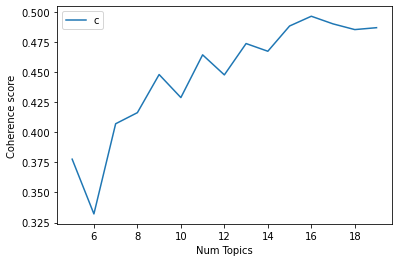

In [17]:
# Show graph
limit=20; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3776
Num Topics = 6  has Coherence Value of 0.3322
Num Topics = 7  has Coherence Value of 0.407
Num Topics = 8  has Coherence Value of 0.4162
Num Topics = 9  has Coherence Value of 0.4478
Num Topics = 10  has Coherence Value of 0.4287
Num Topics = 11  has Coherence Value of 0.4642
Num Topics = 12  has Coherence Value of 0.4476
Num Topics = 13  has Coherence Value of 0.4735
Num Topics = 14  has Coherence Value of 0.4672
Num Topics = 15  has Coherence Value of 0.4881
Num Topics = 16  has Coherence Value of 0.4962
Num Topics = 17  has Coherence Value of 0.4899
Num Topics = 18  has Coherence Value of 0.4851
Num Topics = 19  has Coherence Value of 0.4867


In [19]:
num_topics = 11
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=42)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

Mallet LDA: 11 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 117
total tokens: 22186
<10> LL/token: -8.18212
<20> LL/token: -7.89887
<30> LL/token: -7.75387
<40> LL/token: -7.60942

0	4.54545	population feel good density increase work mixed_use choice reason large environment pick neighborhood support beneficial decrease nice future low matter 
1	4.54545	rent control climate building density people issue decide percent small cap low price rate safe option build crime citizen time 
2	4.54545	housing affordable investor option rent government international service mix city emission involvement investment idea factor long big cap dense increase 
3	4.54545	increase favor profit density idea general good make infrastructure depend year project hard neighborhood living sense involvement create pay mixed 
4	4.54545	development rent neighborhood good community choose area agree opinion control resident people plan home increase change survey current overcrowd project 
5	4.5454

<260> LL/token: -6.84443
<270> LL/token: -6.85053
<280> LL/token: -6.86109
<290> LL/token: -6.83625

0	4.54545	good neighborhood feel environment work choice reason fair pick large build expensive sound beneficial dense mixed future safe interesting reasonable 
1	4.54545	rent important cap climate building apartment control build neutral rate consideration easy inclusion number extremely preference usage grow include zone 
2	4.54545	housing affordable decide option include factor emission social big concern amount job developer provide suit carbon homeless person select favorable 
3	4.54545	make development great idea decision time favour densification government infrastructure general depend nice love find hard create living put small_businesse 
4	4.54545	resident community choose benefit change opinion agree good involve base input give plan survey environmental climate current carbon_neutral national interest 
5	4.54545	prefer project investor profit business mixed_use non_profit lo

<510> LL/token: -6.76865
<520> LL/token: -6.78062
<530> LL/token: -6.78732
<540> LL/token: -6.78708

0	4.54545	good neighborhood feel work environment reason fair pick sound beneficial safe future interesting decrease double point make diversity choice stay 
1	4.54545	rent climate important cap building change build issue neutral rate add consideration apartment find easy extremely company society meet acceptable 
2	4.54545	housing affordable option include factor percentage emission social big concern amount situation carbon_neutral provide job carbon specific restriction preferred majority 
3	4.54545	make development idea great favour time densification general infrastructure depend love hard fit living expensive sense lead country poor happen 
4	4.54545	resident decide choose benefit opinion decision base involve agree input plan give choice environmental current rental view neighbourhood part question 
5	4.54545	prefer project investor profit government business apartment local mix

<760> LL/token: -6.75928
<770> LL/token: -6.75629
<780> LL/token: -6.75025
<790> LL/token: -6.7433

0	4.54545	good neighborhood feel work choice bring reason depend pick safe beneficial concern interesting decrease double diversity effect fair interested comparison 
1	4.54545	rent climate important cap building change build issue neutral long add raise mixed consideration rental goal inclusion rate acceptable extremely 
2	4.54545	housing affordable include percentage factor emission social accept requirement amount sound situation main reasonable provide suitable carbon carbon_neutral free priority 
3	4.54545	make thing development idea great time favour densification infrastructure year type hard expensive job sense living overcrowd lead country point 
4	4.54545	resident decide choose option benefit decision opinion agree base involve input give plan survey love environmental current future view part 
5	4.54545	prefer project investor profit government business apartment local non_pro

[(8,
  [('area', 0.129293893129771),
   ('high', 0.08110687022900763),
   ('environment', 0.03244274809160305),
   ('cost', 0.03101145038167939),
   ('pay', 0.02385496183206107),
   ('life', 0.023377862595419848),
   ('problem', 0.022900763358778626),
   ('space', 0.021469465648854963),
   ('quality', 0.02099236641221374),
   ('crime', 0.019083969465648856)]),
 (9,
  [('rent', 0.48),
   ('control', 0.303),
   ('factor', 0.021),
   ('fair', 0.018),
   ('landlord', 0.0155),
   ('grateful', 0.007),
   ('form', 0.0065),
   ('key', 0.0055),
   ('district', 0.005),
   ('maximum', 0.004)]),
 (7,
  [('increase', 0.3175182481751825),
   ('density', 0.23585766423357665),
   ('population', 0.17974452554744524),
   ('low', 0.040145985401459854),
   ('percent', 0.03193430656934307),
   ('reduce', 0.011405109489051095),
   ('acceptable', 0.008667883211678832),
   ('double', 0.008211678832116789),
   ('oppose', 0.007755474452554745),
   ('reject', 0.005930656934306569)]),
 (3,
  [('make', 0.095848282

In [20]:
# Select the model and print the topics
optimal_model = ldamallet 
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.251*"good" + 0.132*"neighborhood" + 0.091*"feel" + 0.034*"work" + '
  '0.030*"choice" + 0.022*"reason" + 0.021*"depend" + 0.020*"pick" + '
  '0.015*"safe" + 0.015*"rate" + 0.014*"bring" + 0.014*"beneficial" + '
  '0.011*"diversity" + 0.010*"interesting" + 0.008*"criterion" + '
  '0.008*"comparison" + 0.008*"amazing" + 0.008*"develop" + 0.008*"restaurant" '
  '+ 0.008*"positive"'),
 (1,
  '0.102*"climate" + 0.102*"rent" + 0.098*"important" + 0.091*"cap" + '
  '0.065*"building" + 0.060*"change" + 0.043*"build" + 0.029*"issue" + '
  '0.019*"neutral" + 0.015*"mixed" + 0.015*"raise" + 0.015*"fit" + '
  '0.013*"consideration" + 0.011*"inclusion" + 0.010*"extremely" + '
  '0.010*"effect" + 0.010*"goal" + 0.009*"preference" + 0.008*"force" + '
  '0.007*"factor"'),
 (2,
  '0.270*"housing" + 0.187*"affordable" + 0.036*"include" + 0.034*"percentage" '
  '+ 0.022*"accept" + 0.022*"social" + 0.021*"emission" + 0.016*"requirement" '
  '+ 0.016*"amount" + 0.014*"income" + 0.012*"situation" 

### Relate the topics back to the individual responses

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.1044,"resident, decide, choose, option, benefit, dec...",I'm not yo I'm not talking to you
1,1,0.0,0.0909,"good, neighborhood, feel, work, choice, reason...",It is the way it is
2,2,10.0,0.1066,"people, live, city, lot, family, place, price,...",Because it would be more fair to people that d...
3,3,3.0,0.1046,"make, thing, development, idea, great, time, f...",I choose proposal 2 because you offered me bet...
4,4,0.0,0.1259,"good, neighborhood, feel, work, choice, reason...",Because I felt like it wouldn't be good enough...
5,5,5.0,0.1574,"prefer, project, investor, profit, apartment, ...","I prefer the lower density idea, but also mixe..."
6,6,3.0,0.0978,"make, thing, development, idea, great, time, f...",Whatever one sounds better
7,7,8.0,0.1087,"area, high, environment, cost, pay, life, prob...",My positions are better
8,8,0.0,0.1066,"good, neighborhood, feel, work, choice, reason...",This is Good Survey.
9,9,7.0,0.1195,"increase, density, population, low, percent, r...",I don't want the density to double!!


In [22]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1749,"good, neighborhood, feel, work, choice, reason...",I believe that controlling rent is critical in...
1,1.0,0.2311,"climate, rent, important, cap, building, chang...",Climate awareness and rent control are two iss...
2,2.0,0.3011,"housing, affordable, include, percentage, acce...",There should in any development be a decent pe...
3,3.0,0.2600,"make, thing, development, idea, great, time, f...",Goodmayes has two crossings between Goodmayes ...
4,4.0,0.2026,"resident, decide, choose, option, benefit, dec...",I just chose the better option for me. Some I...


In [23]:
for i in range(0,num_topics):
    print("Topic_", i)
    print(sent_topics_sorteddf_mallet['Keywords'][i])
    print(sent_topics_sorteddf_mallet['Text'][i])
    print( )
sent_topics_sorteddf_mallet

Topic_ 0
good, neighborhood, feel, work, choice, reason, depend, pick, safe, rate
I believe that controlling rent is critical in keeping my neighborhood safe and well developed.  If the rent drops, so does the ability of people to maintain safe areas to live, work, and play.

Topic_ 1
climate, rent, important, cap, building, change, build, issue, neutral, mixed
Climate awareness and rent control are two issues that are extremely important here. I also took into account the number of people that would be added (densification). I'd much rather have the government or a non-profit investor. Buildings that have small businesses in the lobby or built in are always welcome here. Inclusion zones are tricky, there are extremely problematic buildings in our neighborhood that have a large percentage of inclusionary zone residents. Rent control is important here, but not the primary issue. 

Topic_ 2
housing, affordable, include, percentage, accept, social, emission, requirement, amount, income
Th

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1749,"good, neighborhood, feel, work, choice, reason...",I believe that controlling rent is critical in...
1,1.0,0.2311,"climate, rent, important, cap, building, chang...",Climate awareness and rent control are two iss...
2,2.0,0.3011,"housing, affordable, include, percentage, acce...",There should in any development be a decent pe...
3,3.0,0.2600,"make, thing, development, idea, great, time, f...",Goodmayes has two crossings between Goodmayes ...
4,4.0,0.2026,"resident, decide, choose, option, benefit, dec...",I just chose the better option for me. Some I...
5,5.0,0.2330,"prefer, project, investor, profit, apartment, ...",Do not want international for-profit investors...
6,6.0,0.1798,"community, favor, involvement, public, general...",The first two categories are generally the mos...
7,7.0,0.2020,"increase, density, population, low, percent, r...",These proposals are generally damaging and deg...
8,8.0,0.3419,"area, high, environment, cost, pay, life, prob...",1. There are a lot of unused buildings sitting...
9,9.0,0.1708,"rent, control, factor, fair, landlord, gratefu...","Ok, the proposals I went with just kept rents ..."


In [24]:
for i in range(0,num_topics):
    print("Topic_", i)
    print("Top 10 Keywords:", sent_topics_sorteddf_mallet['Keywords'][i])
    print("EXAMPLE: ", "'", sent_topics_sorteddf_mallet['Text'][i], "'")
    print( )
sent_topics_sorteddf_mallet

Topic_ 0
Top 10 Keywords: good, neighborhood, feel, work, choice, reason, depend, pick, safe, rate
EXAMPLE:  ' I believe that controlling rent is critical in keeping my neighborhood safe and well developed.  If the rent drops, so does the ability of people to maintain safe areas to live, work, and play. '

Topic_ 1
Top 10 Keywords: climate, rent, important, cap, building, change, build, issue, neutral, mixed
EXAMPLE:  ' Climate awareness and rent control are two issues that are extremely important here. I also took into account the number of people that would be added (densification). I'd much rather have the government or a non-profit investor. Buildings that have small businesses in the lobby or built in are always welcome here. Inclusion zones are tricky, there are extremely problematic buildings in our neighborhood that have a large percentage of inclusionary zone residents. Rent control is important here, but not the primary issue.  '

Topic_ 2
Top 10 Keywords: housing, affordable

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1749,"good, neighborhood, feel, work, choice, reason...",I believe that controlling rent is critical in...
1,1.0,0.2311,"climate, rent, important, cap, building, chang...",Climate awareness and rent control are two iss...
2,2.0,0.3011,"housing, affordable, include, percentage, acce...",There should in any development be a decent pe...
3,3.0,0.2600,"make, thing, development, idea, great, time, f...",Goodmayes has two crossings between Goodmayes ...
4,4.0,0.2026,"resident, decide, choose, option, benefit, dec...",I just chose the better option for me. Some I...
5,5.0,0.2330,"prefer, project, investor, profit, apartment, ...",Do not want international for-profit investors...
6,6.0,0.1798,"community, favor, involvement, public, general...",The first two categories are generally the mos...
7,7.0,0.2020,"increase, density, population, low, percent, r...",These proposals are generally damaging and deg...
8,8.0,0.3419,"area, high, environment, cost, pay, life, prob...",1. There are a lot of unused buildings sitting...
9,9.0,0.1708,"rent, control, factor, fair, landlord, gratefu...","Ok, the proposals I went with just kept rents ..."


In [25]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(12) #.head(25)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,4.0,"resident, decide, choose, option, benefit, dec...",935.0,0.1914
1.0,0.0,"good, neighborhood, feel, work, choice, reason...",435.0,0.0890
2.0,10.0,"people, live, city, lot, family, place, price,...",455.0,0.0931
3.0,3.0,"make, thing, development, idea, great, time, f...",426.0,0.0872
4.0,0.0,"good, neighborhood, feel, work, choice, reason...",490.0,0.1003
5.0,5.0,"prefer, project, investor, profit, apartment, ...",368.0,0.0753
6.0,3.0,"make, thing, development, idea, great, time, f...",355.0,0.0727
7.0,8.0,"area, high, environment, cost, pay, life, prob...",455.0,0.0931
8.0,0.0,"good, neighborhood, feel, work, choice, reason...",291.0,0.0596
9.0,7.0,"increase, density, population, low, percent, r...",361.0,0.0739


In [26]:
df_dominant_topics['Dominant_Topic'].value_counts()

0.0     935
4.0     490
7.0     455
2.0     455
1.0     435
3.0     426
5.0     368
9.0     361
6.0     355
10.0    315
8.0     291
Name: Dominant_Topic, dtype: int64

### Merge topic data and survey data to be able to look at dominant topic prevalance compared to other survey responses

In [27]:
survey_df_w_lda = survey_df.merge(df_dominant_topic, left_index=True, right_index=True)
survey_df_w_lda

,StartDate,EndDate,Progress,Duration..in.seconds.,Finished,RecordedDate,ResponseId,LocationLatitude,LocationLongitude,UserLanguage,...,age,city,country,Q12.6_corrected,response_char_length,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,18.02.21 06:18,18.02.21 06:23,100.0,300.0,Richtig,18.02.21 06:23,R_10PI5FKTTlId8Ec,41.606201,-87.259300,EN-GB,...,18-24,Chicago,United States,I'm not yo I'm not talking to you,34,0,4.0,0.1044,"resident, decide, choose, option, benefit, dec...",I'm not yo I'm not talking to you
1,18.02.21 06:41,18.02.21 06:55,100.0,894.0,Richtig,18.02.21 06:55,R_1gduid1fizdQ4d8,37.983398,-122.031204,EN-GB,...,35-44,Chicago,United States,It is the way it is,19,1,0.0,0.0909,"good, neighborhood, feel, work, choice, reason...",It is the way it is
2,18.02.21 06:45,18.02.21 06:57,100.0,681.0,Richtig,18.02.21 06:57,R_23WCgmyuPAy3b1G,41.741501,-87.596199,EN-GB,...,18-24,Chicago,United States,Because it would be more fair to people that d...,60,2,10.0,0.1066,"people, live, city, lot, family, place, price,...",Because it would be more fair to people that d...
3,18.02.21 06:56,18.02.21 07:11,100.0,941.0,Richtig,18.02.21 07:11,R_1pLEMXp5iJbankG,41.920898,-87.704300,EN-GB,...,35-44,Chicago,United States,I choose proposal 2 because you offered me bet...,74,3,3.0,0.1046,"make, thing, development, idea, great, time, f...",I choose proposal 2 because you offered me bet...
4,18.02.21 09:38,18.02.21 09:50,100.0,676.0,Richtig,18.02.21 09:50,R_2OYEXKWutkzQOmS,42.048706,-87.890503,EN-GB,...,18-24,Chicago,United States,Because I felt like it wouldn't be good enough...,54,4,0.0,0.1259,"good, neighborhood, feel, work, choice, reason...",Because I felt like it wouldn't be good enough...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4881,08.04.21 11:17,08.04.21 11:35,100.0,1099.0,Richtig,08.04.21 11:35,R_1DURra4lLvv0XRx,38.960907,-77.342903,EN-GB,...,55+,New York,United States,The rent should be controlled or capped.,40,4881,9.0,0.1214,"rent, control, factor, fair, landlord, gratefu...",The rent should be controlled or capped.
4882,09.04.21 07:02,09.04.21 07:18,100.0,922.0,Richtig,09.04.21 07:18,R_3IbeaickE6yzMvB,40.126205,-75.526802,EN-GB,...,55+,New York,United States,less expensive to live in the city,34,4882,10.0,0.1235,"people, live, city, lot, family, place, price,...",less expensive to live in the city
4883,12.04.21 12:18,12.04.21 12:33,100.0,869.0,Richtig,12.04.21 12:33,R_31j9KOyo19N4Ry2,40.569702,-74.118401,EN-GB,...,55+,New York,United States,need for infrastructure to be considered when ...,76,4883,7.0,0.1377,"increase, density, population, low, percent, r...",need for infrastructure to be considered when ...
4884,12.04.21 21:08,12.04.21 21:27,100.0,1110.0,Richtig,12.04.21 21:27,R_3m3RswMKOzJ8f6l,40.725800,-73.862000,EN-GB,...,55+,New York,United States,Rent control is important to me.,32,4884,9.0,0.1235,"rent, control, factor, fair, landlord, gratefu...",Rent control is important to me.


In [28]:
survey_df_w_lda[df_dominant_topic['Dominant_Topic']==3.0]['Text']

3       I choose proposal 2 because you offered me bet...
6                              Whatever one sounds better
13                                 Because some are great
29        some communities don't have enough job security
40                  It's very explanative and descriptive
                              ...                        
4854          Some proposals make more sense than others 
4862                          too much money being wasted
4864          because some are more expensive than others
4868                                 Just my gut reaction
4870    This is a suburb that type of housing belongs ...
Name: Text, Length: 426, dtype: object

### Climate subgroups

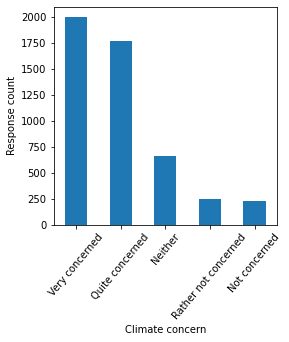

,count,mean,std,min,25%,50%,75%,max
Q14.9,,,,,,,,
Neither,656.0,3.992378,3.306012,0.0,1.0,4.0,7.0,10.0
Not concerned,224.0,4.892857,3.090147,0.0,3.0,5.0,7.0,10.0
Quite concerned,1765.0,4.239093,3.215176,0.0,1.0,4.0,7.0,10.0
Rather not concerned,248.0,4.745968,3.387878,0.0,2.0,5.0,7.0,10.0
Very concerned,1993.0,4.059709,3.265517,0.0,1.0,4.0,7.0,10.0


In [29]:
# Groupby by climate
climate = survey_df_w_lda.groupby('Q14.9')

plt.figure(figsize=(4,4))
climate.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Climate concern")
plt.ylabel("Response count")
plt.show()

# Summary statistic of all countries
climate['Dominant_Topic'].describe().head()

In [30]:
scale_mapper = {'Not concerned': -2, 'Rather not concerned': -1, 'Neither': 0, 'Quite concerned': 1, 'Very concerned': 2}
survey_df_w_lda["level_climate_concern"] = survey_df_w_lda["Q14.9"].replace(scale_mapper)
survey_df_w_lda

summary_df = survey_df_w_lda[["level_climate_concern", 'Dominant_Topic']] #)#['Dominant_Topic']#.count()
print(len(summary_df))
summary_df.head()

4886


,level_climate_concern,Dominant_Topic
0,0,4.0
1,2,0.0
2,2,10.0
3,0,3.0
4,2,0.0


In [31]:
cross_tab_prop = pd.crosstab(index=summary_df['level_climate_concern'],
                             columns=summary_df['Dominant_Topic'],
                             normalize="index")
climate_v_lda = cross_tab_prop
climate_v_lda['level_climate_concern'] = climate_v_lda.index.copy()
#cross_tab_prop = cross_tab_prop.reindex(index = ['Not concerned', 'Rather not concerned', 'Neither', 'Quite concerned', 'Very concerned'])
cross_tab_prop #cross_tab_prop.sort_values('very-not concerned', ascending=False) #.corr()
climate_v_lda.corr()
df_corr = climate_v_lda.corr()

<Figure size 864x864 with 0 Axes>

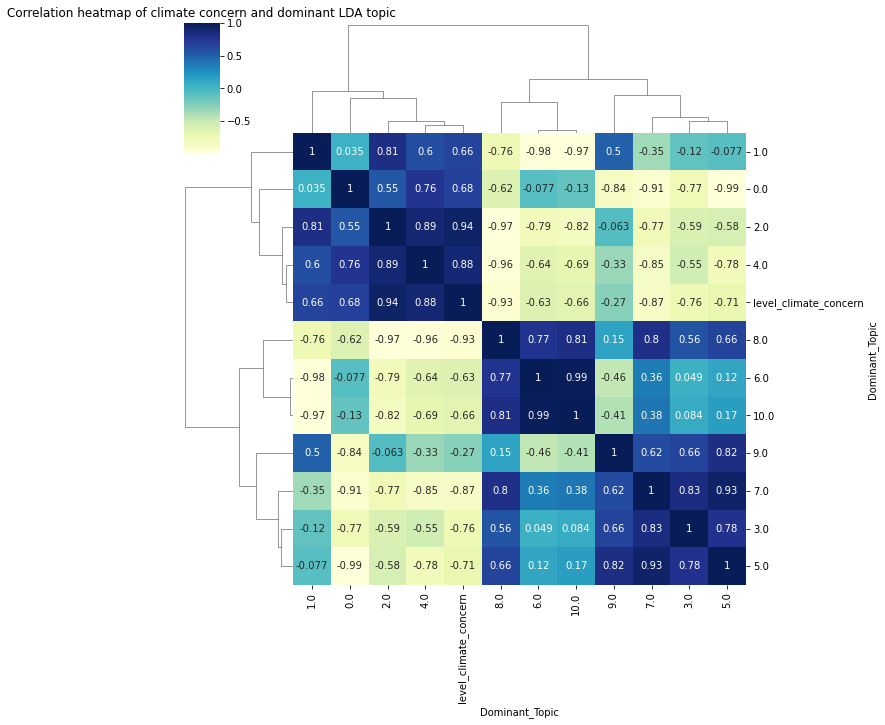

In [32]:
#make heatmap of plot above
plt.figure(figsize=(12, 12))
corr = df_corr.corr(method='spearman') #[['A']]
ax = sns.clustermap(corr, #corr[["level_climate_concern"]],
                 robust=True, 
                 annot=True,  
                 cmap="YlGnBu")

title = ("Correlation heatmap of climate concern and dominant LDA topic" )
plt.title(title)
file_name=('../../figures/' + title + ('_v1_spearman.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')

In [33]:
summary_df = survey_df_w_lda[['Q14.9', 'Dominant_Topic']] #)#['Dominant_Topic']#.count()
print(len(summary_df))
summary_df.head()

cross_tab_prop = pd.crosstab(index=summary_df['Dominant_Topic'],
                             columns=summary_df['Q14.9'],
                             normalize="index")

cross_tab_prop['very-not concerned'] =  cross_tab_prop['Very concerned'] - cross_tab_prop['Not concerned'] #.describe()
cross_tab_prop.sort_values('very-not concerned', ascending=False)

4886


Q14.9,Neither,Not concerned,Quite concerned,Rather not concerned,Very concerned,very-not concerned
Dominant_Topic,,,,,,
1.0,0.105747,0.043678,0.328736,0.022989,0.498851,0.455172
2.0,0.116484,0.026374,0.380220,0.028571,0.448352,0.421978
0.0,0.164706,0.025668,0.346524,0.053476,0.409626,0.383957
9.0,0.113573,0.058172,0.371191,0.041551,0.415512,0.357341
5.0,0.095109,0.067935,0.364130,0.054348,0.418478,0.350543
4.0,0.140816,0.040816,0.383673,0.044898,0.389796,0.348980
8.0,0.134021,0.058419,0.340206,0.065292,0.402062,0.343643
10.0,0.142857,0.047619,0.336508,0.085714,0.387302,0.339683
6.0,0.126761,0.045070,0.391549,0.067606,0.369014,0.323944


<Figure size 432x432 with 0 Axes>

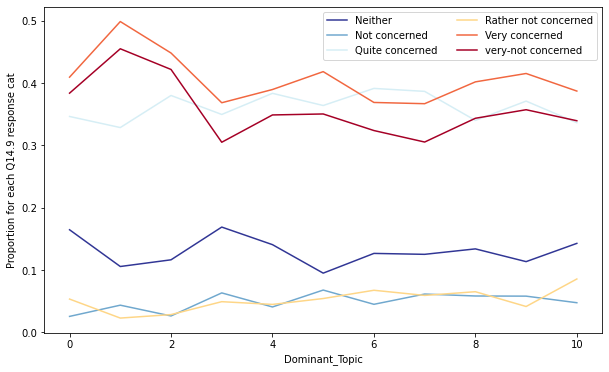

In [34]:
#make colormap: 
clrs = cm.get_cmap('RdYlBu_r', 22)

plt.figure(figsize=(6, 6))
cross_tab_prop.plot(kind='line', 
                    colormap=clrs, 
                    figsize=(10, 6))
plt.legend(bbox_to_anchor=(1.0, 1.0), ncol=2)
#plt.xlabel("Release Year")
plt.ylabel("Proportion for each Q14.9 response cat")
plt.show()

In [35]:
cross_tab_prop = pd.crosstab(index=summary_df['Q14.9'],
                             columns=summary_df['Dominant_Topic'],
                             normalize="index")

cross_tab_prop = cross_tab_prop.reindex(index = ['Not concerned', 'Rather not concerned', 'Neither', 'Quite concerned', 'Very concerned'])

cross_tab = pd.crosstab(index=summary_df['Q14.9'],
                        columns=summary_df['Dominant_Topic'])

cross_tab = cross_tab.reindex(index = ['Not concerned', 'Rather not concerned', 'Neither', 'Quite concerned', 'Very concerned'])
cross_tab

Dominant_Topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Q14.9,,,,,,,,,,,
Not concerned,24,19,12,27,20,25,16,28,17,21,15
Rather not concerned,50,10,13,21,22,20,24,27,19,15,27
Neither,154,46,53,72,69,35,45,57,39,41,45
Quite concerned,324,143,173,149,188,134,139,176,99,134,106
Very concerned,383,217,204,157,191,154,131,167,117,150,122


<Figure size 432x432 with 0 Axes>

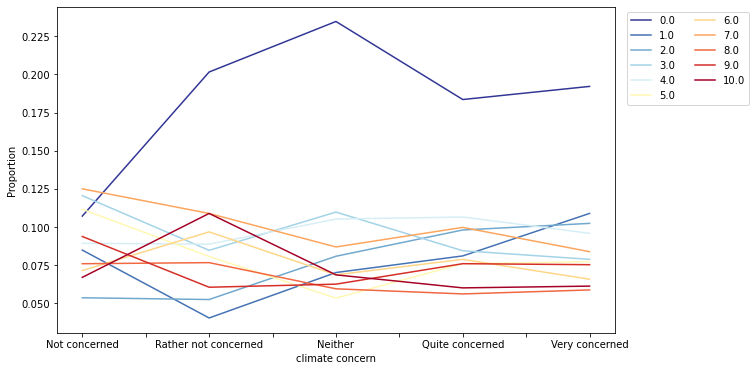

In [36]:
plt.figure(figsize=(6, 6))
cross_tab_prop.plot(kind='line', 
                    colormap=clrs, 
                    figsize=(10, 6))
plt.legend(bbox_to_anchor=(1.25, 1.00), ncol=2)
plt.xlabel("climate concern")
plt.ylabel("Proportion")
plt.show()

4886


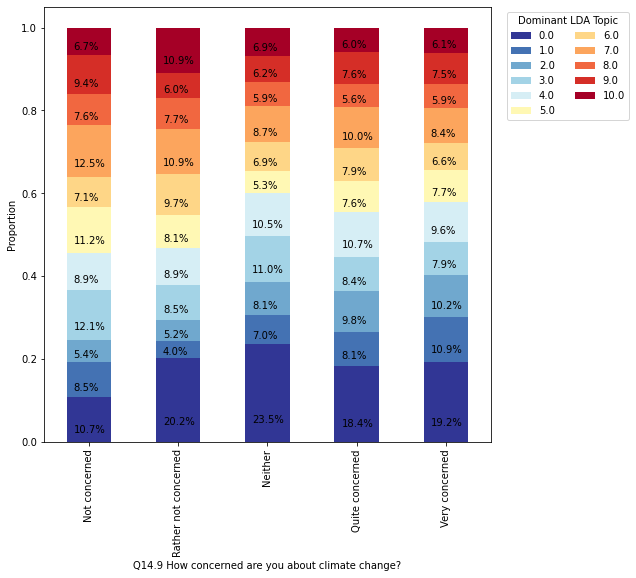

In [37]:
summary_df = survey_df_w_lda[['Q14.9', 'Dominant_Topic']] #)#['Dominant_Topic']#.count()
print(len(summary_df))
summary_df.head()

cross_tab_prop = pd.crosstab(index=summary_df['Q14.9'],
                             columns=summary_df['Dominant_Topic'],
                             normalize="index")

cross_tab_prop = cross_tab_prop.reindex(index = ['Not concerned', 'Rather not concerned', 'Neither', 'Quite concerned', 'Very concerned'])
cross_tab_prop 

cross_tab= pd.crosstab(index=summary_df['Q14.9'],
                             columns=summary_df['Dominant_Topic'])

cross_tab = cross_tab.reindex(index = ['Not concerned', 'Rather not concerned', 'Neither', 'Quite concerned', 'Very concerned'])
cross_tab

cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap=clrs, 
                    figsize=(8, 8))


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=(y_loc - proportion) + (proportion / 5),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=10) #,
                 #fontweight="bold")

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Q14.9 How concerned are you about climate change?")
plt.ylabel("Proportion")
plt.legend(title='Dominant LDA Topic', bbox_to_anchor=(1.025, 1.00), ncol=2)
fig_name = 'stacked_bar'
file_name=('../../figures/' + fig_name + ('_ldamallet_12_topic_proportion_across_Q14.9.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

### Acceptance/Rejection of densification projects

In [38]:
summary_df = survey_df_w_lda[['Q7.5', 'Dominant_Topic']] #)#['Dominant_Topic']#.count()
print(len(summary_df))
summary_df.head()

cross_tab_prop = pd.crosstab(index=summary_df['Q7.5'],
                             columns=summary_df['Dominant_Topic'],
                             normalize="index")

cross_tab_prop = cross_tab_prop.reindex(index = ['always reject', 'reject', 'mostly reject', 'undecided', 'mostly accept', 'accept', 'always accept'])
cross_tab_prop 

4886


Dominant_Topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Q7.5,,,,,,,,,,,
always reject,0.150350,0.083916,0.094406,0.094406,0.048951,0.062937,0.059441,0.164336,0.111888,0.041958,0.087413
reject,0.133333,0.097917,0.068750,0.077083,0.075000,0.093750,0.041667,0.147917,0.097917,0.087500,0.079167
mostly reject,0.113208,0.109164,0.097035,0.080863,0.064690,0.110512,0.057951,0.153639,0.084906,0.066038,0.061995
undecided,0.164666,0.078045,0.115780,0.105489,0.102058,0.074614,0.072041,0.078902,0.054889,0.087479,0.066038
mostly accept,0.180812,0.104244,0.115314,0.078413,0.108856,0.075646,0.086716,0.071956,0.035055,0.087638,0.055351
accept,0.299410,0.070796,0.063422,0.076696,0.128319,0.045723,0.088496,0.056047,0.041298,0.064897,0.064897
always accept,0.340000,0.068889,0.044444,0.093333,0.151111,0.051111,0.082222,0.033333,0.042222,0.037778,0.055556


In [39]:
cross_tab= pd.crosstab(index=summary_df['Q7.5'],
                             columns=summary_df['Dominant_Topic'])

cross_tab = cross_tab.reindex(index = ['always reject', 'reject', 'mostly reject', 'undecided', 'mostly accept', 'accept', 'always accept'])
cross_tab

Dominant_Topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Q7.5,,,,,,,,,,,
always reject,43,24,27,27,14,18,17,47,32,12,25
reject,64,47,33,37,36,45,20,71,47,42,38
mostly reject,84,81,72,60,48,82,43,114,63,49,46
undecided,192,91,135,123,119,87,84,92,64,102,77
mostly accept,196,113,125,85,118,82,94,78,38,95,60
accept,203,48,43,52,87,31,60,38,28,44,44
always accept,153,31,20,42,68,23,37,15,19,17,25


<Figure size 432x432 with 0 Axes>

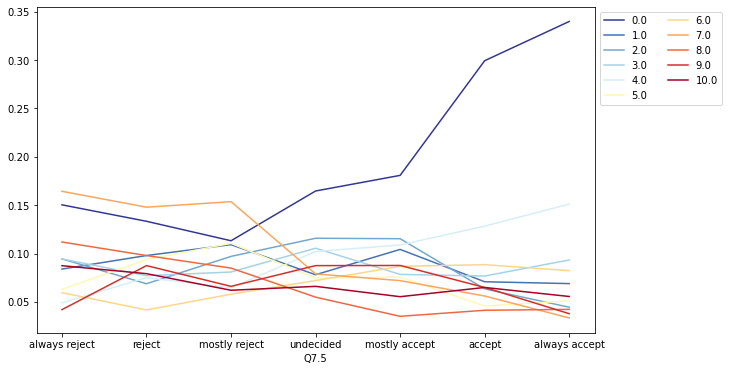

In [40]:
plt.figure(figsize=(6, 6))
cross_tab_prop.plot(kind='line', 
                    colormap=clrs, 
                    figsize=(10, 6))
plt.legend(bbox_to_anchor=(1.0, 1.0), ncol=2)
plt.show()

4886


<Figure size 432x432 with 0 Axes>

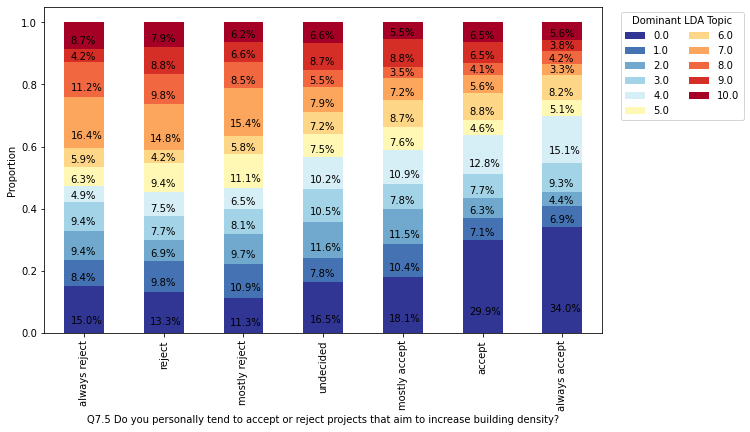

In [41]:
summary_df = survey_df_w_lda[['Q7.5', 'Dominant_Topic']] #)#['Dominant_Topic']#.count()
print(len(summary_df))
summary_df.head()

cross_tab_prop = pd.crosstab(index=summary_df['Q7.5'],
                             columns=summary_df['Dominant_Topic'],
                             normalize="index")

cross_tab_prop = cross_tab_prop.reindex(index = ['always reject', 'reject', 'mostly reject', 'undecided', 'mostly accept', 'accept', 'always accept'])

cross_tab= pd.crosstab(index=summary_df['Q7.5'],
                             columns=summary_df['Dominant_Topic'])

cross_tab = cross_tab.reindex(index = ['always reject', 'reject', 'mostly reject', 'undecided', 'mostly accept', 'accept', 'always accept'])


clrs = cm.get_cmap('RdYlBu_r', 22)

plt.figure(figsize=(6, 6))
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap=clrs, 
                    figsize=(10, 6))


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=(y_loc - proportion) + (proportion / 5),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=10) #,
                 #fontweight="bold")

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Q7.5 Do you personally tend to accept or reject projects that aim to increase building density?")
plt.ylabel("Proportion")
plt.legend(title='Dominant LDA Topic', bbox_to_anchor=(1.025, 1.00), ncol=2)
fig_name = 'stacked_bar'
file_name=('../../figures/' + fig_name + ('_ldamallet_%s_topic_proportion_across_Q7.5.png' % num_topics))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

### Frame

4886


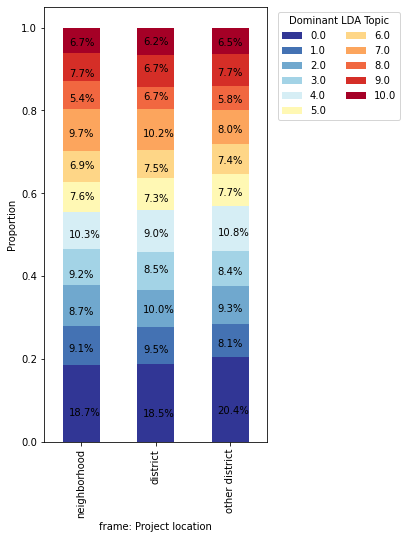

In [42]:
summary_df = survey_df_w_lda[['frame', 'Dominant_Topic']] #)#['Dominant_Topic']#.count()
print(len(summary_df))
summary_df.head()

cross_tab_prop = pd.crosstab(index=summary_df['frame'],
                             columns=summary_df['Dominant_Topic'],
                             normalize="index")

cross_tab_prop = cross_tab_prop.reindex(index = ['neighborhood', 'district', 'other district'])
cross_tab_prop 

cross_tab= pd.crosstab(index=summary_df['frame'],
                             columns=summary_df['Dominant_Topic'])

cross_tab_prop = cross_tab_prop.reindex(index = ['neighborhood', 'district', 'other district'])
cross_tab

cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap=clrs, 
                    figsize=(4, 8))


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=(y_loc - proportion) + (proportion / 3),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=10) #,
                 #fontweight="bold")

plt.legend(loc="upper left", ncol=2)
plt.xlabel("frame: Project location")
plt.ylabel("Proportion")
plt.legend(title='Dominant LDA Topic', bbox_to_anchor=(1.025, 1.00), ncol=2)
fig_name = 'stacked_bar'
file_name=('../../figures/' + fig_name + ('_ldamallet_%s_topic_proportion_across_frame.png' % num_topics))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

### Political leaning

4886


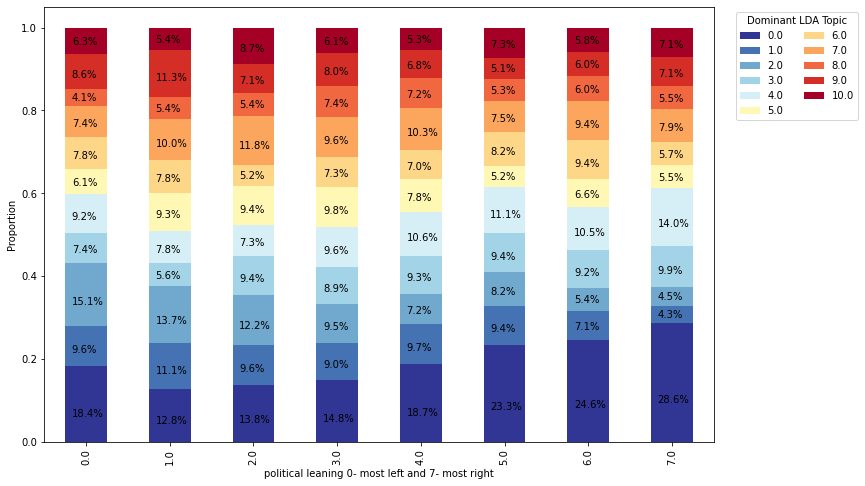

In [43]:
summary_df = survey_df_w_lda[['Q14.1_1', 'Dominant_Topic']] #)#['Dominant_Topic']#.count()
print(len(summary_df))
summary_df.head()

cross_tab_prop = pd.crosstab(index=summary_df['Q14.1_1'],
                             columns=summary_df['Dominant_Topic'],
                             normalize="index")


cross_tab= pd.crosstab(index=summary_df['Q14.1_1'],
                             columns=summary_df['Dominant_Topic'])


cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap=clrs, 
                    figsize=(12, 8))


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=(y_loc - proportion) + (proportion / 3),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=10) #,
                 #fontweight="bold")

plt.legend(loc="upper left", ncol=2)
plt.xlabel("political leaning 0- most left and 7- most right")
plt.ylabel("Proportion")
plt.legend(title='Dominant LDA Topic', bbox_to_anchor=(1.025, 1.00), ncol=2)
fig_name = 'stacked_bar'
file_name=('../../figures/' + fig_name + ('_ldamallet_%s_topic_proportion_across_Q14.1_1.png' % num_topics))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

### City

4886


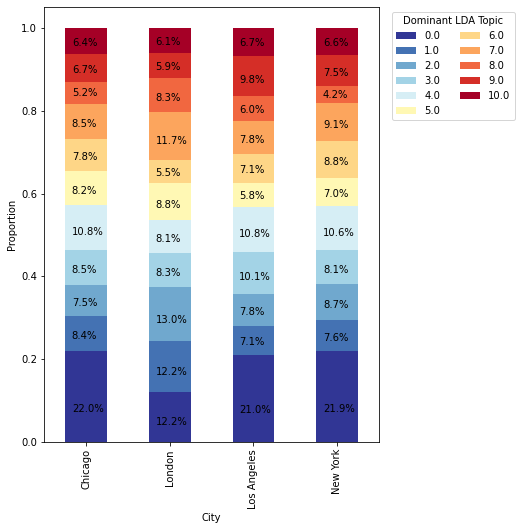

In [44]:
summary_df = survey_df_w_lda[['city', 'Dominant_Topic']] #)#['Dominant_Topic']#.count()
print(len(summary_df))
summary_df.head()

cross_tab_prop = pd.crosstab(index=summary_df['city'],
                             columns=summary_df['Dominant_Topic'],
                             normalize="index")


cross_tab= pd.crosstab(index=summary_df['city'],
                             columns=summary_df['Dominant_Topic'])


cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap=clrs, 
                    figsize=(6, 8))


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=(y_loc - proportion) + (proportion / 3),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=10) #,
                 #fontweight="bold")

plt.legend(loc="upper left", ncol=2)
plt.xlabel("City")
plt.ylabel("Proportion")
plt.legend(title='Dominant LDA Topic', bbox_to_anchor=(1.025, 1.00), ncol=2)
fig_name = 'stacked_bar'
file_name=('../../figures/' + fig_name + ('_ldamallet_%s_topic_proportion_across_city.png' % num_topics))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

### Retrieve the topic scores for each response

In [45]:
#NOTE: topic scores for each response stored in optimal_model[corpus]
print(len(optimal_model[corpus]), len(corpus))

def retrieve_lda_proportions_df(results, num_topics):
    results_list = []
    num_docs = len(results)
    for i in range(0, num_docs): 
        row = results[i]
        items = [row[j][1] for j in range(0, num_topics)]
        results_list.append(items)
    array = np.reshape(results_list, (num_docs, num_topics))
    df = pd.DataFrame(data=array, index=list(range(0, len(array))), columns=[('Topic_' + str(i)) for i in range(0, num_topics)])
    return df

lda_topic_df = retrieve_lda_proportions_df(optimal_model[corpus], num_topics)
lda_topic_df.head()

4886 4886


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10
0,0.093484,0.089127,0.089127,0.089127,0.104377,0.089127,0.089127,0.089127,0.089127,0.089127,0.089127
1,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
2,0.087413,0.087413,0.087413,0.089549,0.087413,0.087413,0.087413,0.087413,0.087413,0.104507,0.106643
3,0.085763,0.085763,0.085763,0.104631,0.104631,0.085763,0.104631,0.085763,0.085763,0.085763,0.085763
4,0.125874,0.087413,0.087413,0.087413,0.087413,0.087413,0.087413,0.087413,0.087413,0.087413,0.087413


## Write output files for linear models 

In [46]:
#df_dominant_topic.to_csv('../datasets/spur_ldamallet_df_dominant_topic_11.txt', sep='\t')
#sent_topics_sorteddf_mallet.to_csv('../datasets/spur_sent_topics_sorteddf_mallet_11.txt', sep='\t')
#df_dominant_topics.head(num_topics).to_csv('../datasets/spur_ldamallet_df_dominant_topics_11.txt', sep='\t')
#survey_df_w_lda.to_csv('../datasets/spur_survey_df_w_lda_11.txt', sep='\t')
#lda_topic_df.to_csv('../datasets/spur_lda_topic_df_11_feb2022_v1.txt', sep='\t')

## Building linear models for the IMCEs with the topic scores from LDA

In [47]:
# package imports
import statsmodels.formula.api as smf

#read in recoded data with IMCEs for the linear model: 
recoded_df = pd.read_csv('../datasets/spur_survey_response_filtered_df1_for_stm.txt', sep='\t')
recoded_df.head()

### look at IMCE data for the responses
lda_cols_to_use = ['ResponseId', 'Q12.6_corrected', 'response_char_length', 'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib']
df_for_lm = survey_df_w_lda[lda_cols_to_use]
df_for_lm = recoded_df.merge(df_for_lm, how='left', left_on='id', right_on='ResponseId')
df_for_lm = df_for_lm.merge(lda_topic_df, how='left', left_index=True, right_index=True)

#write out 
#df_for_lm.to_csv('../datasets/spur_df_for_lm_feb2022_11_v1.txt', sep='\t')

df_for_lm.head()

,id,doc,frame,minority,linguistic_minority,religious_minority,social_class_minority,sexual_orientation_minority,ethnic_minority,national_minority,...,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10
0,R_10PI5FKTTlId8Ec,I'm not yo I'm not talking to you,other district,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.089127,0.089127,0.089127,0.104377,0.089127,0.089127,0.089127,0.089127,0.089127,0.089127
1,R_1gduid1fizdQ4d8,It is the way it is,other district,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
2,R_23WCgmyuPAy3b1G,Because it would be more fair to people that d...,other district,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.087413,0.087413,0.089549,0.087413,0.087413,0.087413,0.087413,0.087413,0.104507,0.106643
3,R_1pLEMXp5iJbankG,I choose proposal 2 because you offered me bet...,other district,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.085763,0.085763,0.104631,0.104631,0.085763,0.104631,0.085763,0.085763,0.085763,0.085763
4,R_2OYEXKWutkzQOmS,Because I felt like it wouldn't be good enough...,other district,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.087413,0.087413,0.087413,0.087413,0.087413,0.087413,0.087413,0.087413,0.087413,0.087413


In [48]:
form_dens = ('imce_dens ~ Topic_0 + Topic_1 + Topic_2 + Topic_3 + Topic_4 + Topic_5 + Topic_6 + Topic_7 + Topic_8 + Topic_9 + Topic_10') 
form_dens_cov = ('imce_dens ~ Topic_0 + Topic_1 + Topic_2 + Topic_3 + Topic_4 + Topic_5 + Topic_6 + Topic_7 + Topic_8 + Topic_9 + Topic_10 + frame + income + city + country + age + gender + minority + political_left_right') 

model_dens = smf.ols(formula= form_dens, data = df_for_lm).fit()
model_dens_cov = smf.ols(formula= form_dens_cov, data = df_for_lm).fit()

##Print coefficients, standard errors, t-stat, p-value and confidence interval
print(model_dens.summary())

##Print coefficients, standard errors, t-stat, p-value and confidence interval
print(model_dens_cov.summary())

                            OLS Regression Results                            
Dep. Variable:              imce_dens   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     16.31
Date:                Fri, 18 Feb 2022   Prob (F-statistic):           2.44e-29
Time:                        19:48:08   Log-Likelihood:                -708.82
No. Observations:                4886   AIC:                             1440.
Df Residuals:                    4875   BIC:                             1511.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5328      0.004    144.852      0.0

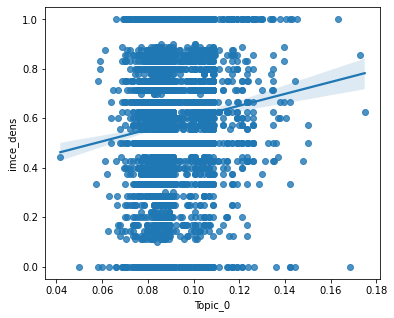

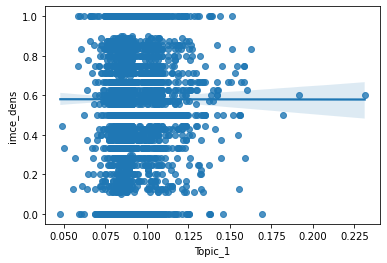

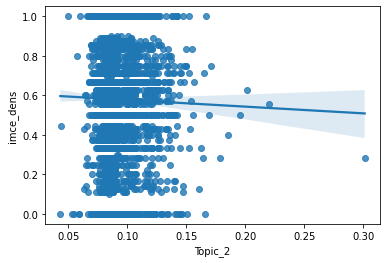

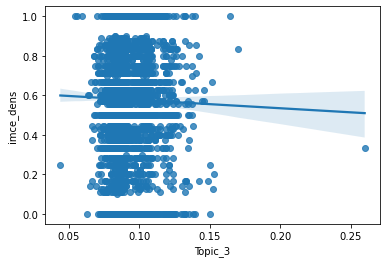

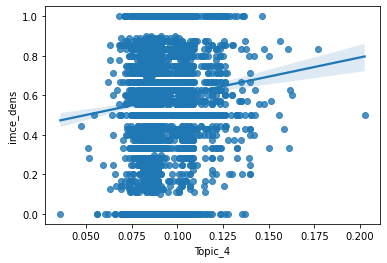

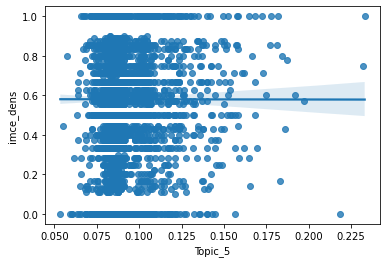

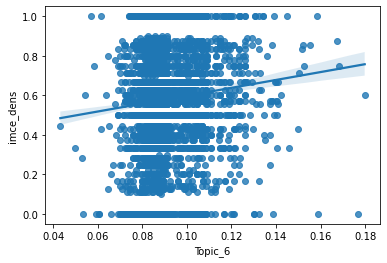

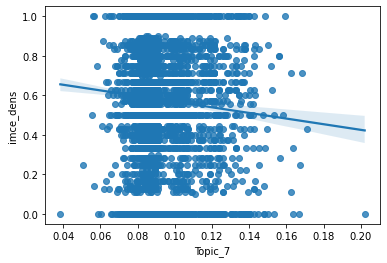

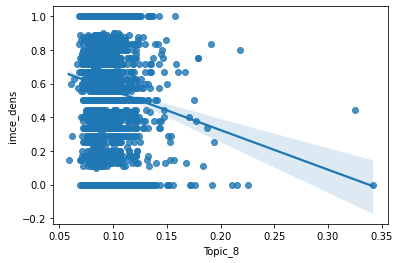

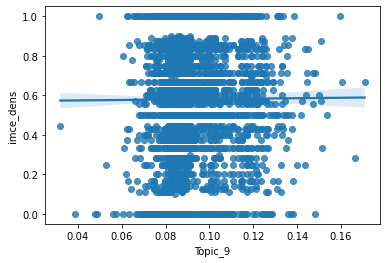

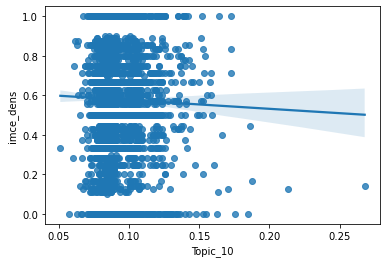

Text(18.106250000000003, 0.5, 'imce_dens')

In [49]:
plt.figure(figsize=(6,5))
for topic in lda_topic_df.columns: 
    ax = sns.regplot(data=df_for_lm, x=topic, y='imce_dens') #, hue='union')
    plt.show()
sns.set_style("ticks")
sns.despine(ax=ax, top=True, right=True, left=False, bottom=True)
ax.set_ylabel('imce_dens')